Let's put all the pieces together, and train a model:

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

First, we'll need training and test datasets. If you haven't already, run the cell below to make sure the dataset is downloaded. (It may take a minute.)

In [2]:
BATCH_SIZE = 16
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomCrop(32,padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split='train',
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classes_with_rejection = classes + ('UNKNOWN',)

Using downloaded and verified file: ./data/train_32x32.mat


We'll run our check on the output from `DataLoader`:

         5          2          5          1          5          8          9          3
         4          3          5          7          1          1          8          2


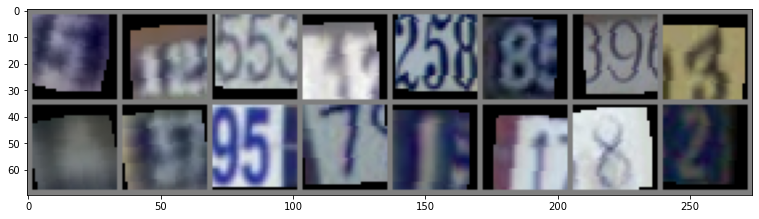

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (13,13))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [4]:
import sys 
sys.path.append('..')
use_cuda = torch.cuda.is_available()
print("use_cuda", use_cuda)

use_cuda True


In [5]:
model_path = "svhn.pth"
model = torch.load(model_path)
if use_cuda: model = model.cuda()

In [6]:
class SelfAdativeTraining():
    def __init__(self, num_examples=50000, num_classes=10, mom=0.9):
        self.prob_history = torch.zeros(num_examples, num_classes)
        self.updated = torch.zeros(num_examples, dtype=torch.int)
        self.mom = mom
        self.num_classes = num_classes

    def _update_prob(self, prob, index, y):
        onehot = torch.zeros_like(prob)
        onehot[torch.arange(y.shape[0]), y] = 1
        prob_history = self.prob_history[index].clone().to(prob.device)

        # if not inited, use onehot label to initialize runnning vector
        cond = (self.updated[index] == 1).to(prob.device).unsqueeze(-1).expand_as(prob)
        prob_mom = torch.where(cond, prob_history, onehot)

        # momentum update
        prob_mom = self.mom * prob_mom + (1 - self.mom) * prob

        self.updated[index] = 1
        self.prob_history[index] = prob_mom.to(self.prob_history.device)

        return prob_mom

    def __call__(self, logits, y, index):
        prob = F.softmax(logits.detach()[:, :self.num_classes], dim=1)
        prob = self._update_prob(prob, index, y)

        soft_label = torch.zeros_like(logits)
        soft_label[torch.arange(y.shape[0]), y] = prob[torch.arange(y.shape[0]), y]
        soft_label[:, -1] = 1 - prob[torch.arange(y.shape[0]), y]
        soft_label = F.normalize(soft_label, dim=1, p=1)
        loss = torch.sum(-F.log_softmax(logits, dim=1) * soft_label, dim=1)
        return torch.mean(loss)

In [7]:
criterion = SelfAdativeTraining(num_examples=len(trainset), num_classes=len(classes), mom=.99)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9, weight_decay=5e-4)

In [32]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

True labels
         2          8          9          9          6          2          3          1
         9          3          3          1          7          2          6          5
Predicted labels
         2          8          9          9          6          2          3          1
         9          3    UNKNOWN          1          7          2          6          5


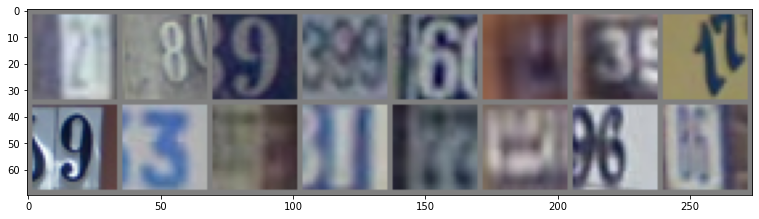

In [9]:
# get some random training images
found_doubt = False
dataiter = iter(testloader)
while found_doubt == False:
    images, labels = dataiter.next()
    initial_outputs = model(images).cpu()
    values, predictions = initial_outputs.data.max(1)
    outputs = F.softmax(initial_outputs, dim=1)
    reservation = outputs[:,-1]
    found_doubt = np.any(np.argmax(outputs.detach().numpy(), axis=1) == 10)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("True labels")
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))
print("Predicted labels")
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [10]:
print("Values", values)
print("predictions indices", np.where(predictions == 10))
print("predictions", values[predictions == 10])
print("Probs")
print(classes_with_rejection)
print(outputs[np.where(predictions == 10)].detach().numpy())

Values tensor([6.8249, 6.7504, 6.8909, 6.8128, 6.8977, 6.8064, 6.9344, 6.8460, 6.8521,
        6.8726, 4.2814, 7.1398, 6.4844, 6.8622, 7.0337, 5.7503])
predictions indices (array([10]),)
predictions tensor([4.2814])
Probs
('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'UNKNOWN')
[[0.002 0.002 0.002 0.431 0.006 0.003 0.001 0.012 0.014 0.001 0.526]]


No misclassification found

In [11]:
# print("Misclassifications", np.where(predictions.eq(labels.data).numpy() == False))
# print("Probs of misclassification")
# print(classes_with_rejection)
# print(outputs[np.where(predictions.eq(labels.data).numpy() == False)].detach().numpy())

In [12]:
print(reservation.detach().numpy() )

[0.146 0.154 0.16  0.189 0.153 0.189 0.158 0.181 0.159 0.153 0.526 0.132
 0.211 0.145 0.158 0.355]


In [13]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[k-1].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
abstention_results = []
top1 = AverageMeter()
top5 = AverageMeter()
generator = iter(testloader)
print("Total batches ", len(generator))
for batch_idx in range(len(generator)):
    batch_data = next(generator)
    inputs, labels = batch_data
    
    if use_cuda:
        inputs = inputs.cuda()
    inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

    with torch.no_grad():
        outputs = model(inputs).cpu()
        values, predictions = outputs.data.max(1)
        outputs = F.softmax(outputs, dim=1)
        outputs, reservation = outputs[:,:-1], outputs[:,-1]
        print("Batch: ", batch_idx)
        abstention_result = list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))
        print(abstention_result)
        abstention_results.extend(abstention_result)
        prec1, prec5 = accuracy(outputs.data, labels.data, topk=(1, 5))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))
    
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))

Total batches  4579
Batch:  0
[(0.15213208, True), (0.15038311, True), (0.1594527, True), (0.15828985, True), (0.12187046, True), (0.16095601, True), (0.15287116, True), (0.16371396, True), (0.12601304, True), (0.14673781, True), (0.19362837, True), (0.1574068, True), (0.15942937, True), (0.15117915, True), (0.1520242, True), (0.18844876, True)]
Batch:  1
[(0.15710247, True), (0.15536518, True), (0.14600806, True), (0.15665069, True), (0.2533354, True), (0.16487747, True), (0.14498591, True), (0.16151443, True), (0.13125698, True), (0.15606359, True), (0.15557322, True), (0.13849394, True), (0.15124543, True), (0.12989369, True), (0.16648716, True), (0.14943823, True)]
Batch:  2
[(0.1328675, True), (0.12764241, True), (0.1280775, True), (0.21156846, True), (0.1585487, True), (0.16288558, True), (0.16024713, True), (0.14572816, True), (0.16053836, True), (0.14311323, True), (0.15525816, True), (0.16333361, True), (0.16271701, True), (0.12902032, True), (0.17752124, True), (0.15225823, T

Batch:  42
[(0.12677184, True), (0.1529021, True), (0.12712231, True), (0.15720756, True), (0.12966724, True), (0.15625869, True), (0.15380622, True), (0.15806806, True), (0.15670383, True), (0.1296133, True), (0.16602366, True), (0.16310883, True), (0.1575235, True), (0.16228338, True), (0.13165107, True), (0.16292974, True)]
Batch:  43
[(0.15485846, True), (0.12588792, True), (0.15129824, True), (0.13451429, True), (0.1569817, True), (0.15391086, True), (0.14876817, True), (0.1407043, True), (0.15083313, True), (0.16225916, True), (0.15272576, True), (0.16194251, True), (0.17201304, True), (0.15075646, True), (0.14487936, True), (0.15967979, True)]
Batch:  44
[(0.14456704, True), (0.12342651, True), (0.15809932, True), (0.18344209, True), (0.12596203, True), (0.1570872, True), (0.15281524, True), (0.16118616, True), (0.15264992, False), (0.15010585, True), (0.16596532, True), (0.1627202, True), (0.20354538, True), (0.13648841, True), (0.1597063, True), (0.1509554, True)]
Batch:  45
[

Batch:  68
[(0.14836287, True), (0.2934358, True), (0.15994631, True), (0.16522484, True), (0.14567235, True), (0.14201939, True), (0.16287872, True), (0.13698766, True), (0.1558939, True), (0.1440379, True), (0.12526593, True), (0.15677024, True), (0.18117346, True), (0.19479308, True), (0.15311022, True), (0.16081588, True)]
Batch:  69
[(0.15958208, True), (0.14773478, True), (0.15450625, True), (0.15866992, True), (0.1488527, True), (0.22223587, True), (0.14231887, True), (0.15988658, True), (0.20407794, True), (0.1470117, True), (0.13158114, True), (0.15298888, True), (0.67682403, False), (0.4553184, True), (0.1467769, True), (0.1533823, True)]
Batch:  70
[(0.12426013, True), (0.14301793, True), (0.1472829, True), (0.14825287, True), (0.1558753, True), (0.22622475, True), (0.14480588, True), (0.14486164, True), (0.15450516, True), (0.14721222, True), (0.13584557, True), (0.1509783, True), (0.15778235, True), (0.16126749, True), (0.15411316, True), (0.15142752, True)]
Batch:  71
[(0

Batch:  94
[(0.15578662, True), (0.2911706, True), (0.16677263, True), (0.14867628, True), (0.14151694, True), (0.15942194, True), (0.15989554, True), (0.1636371, True), (0.15678081, True), (0.1670325, True), (0.15665904, True), (0.17627245, True), (0.16973694, True), (0.16299793, True), (0.15952258, True), (0.1523944, True)]
Batch:  95
[(0.15049475, True), (0.25136575, True), (0.15903899, True), (0.1832067, True), (0.2029421, True), (0.16488773, True), (0.15424924, True), (0.1675392, True), (0.13738325, True), (0.15197277, True), (0.12789331, True), (0.16117337, True), (0.12790431, True), (0.16042124, True), (0.15957238, True), (0.14615856, True)]
Batch:  96
[(0.13239042, True), (0.20020783, True), (0.1444726, True), (0.16408628, True), (0.5446539, False), (0.12488922, True), (0.16068248, True), (0.14011905, True), (0.15854779, True), (0.15773675, True), (0.15655796, True), (0.14274065, True), (0.14373936, True), (0.15052678, True), (0.16454445, True), (0.20801611, True)]
Batch:  97
[

Batch:  121
[(0.42860544, False), (0.19930053, True), (0.13637315, True), (0.15968163, True), (0.12617064, True), (0.16344756, True), (0.14857791, True), (0.14471759, True), (0.15456963, True), (0.14099465, True), (0.1640849, True), (0.14463826, True), (0.2326263, True), (0.15462853, True), (0.14272843, True), (0.1433154, True)]
Batch:  122
[(0.15993813, True), (0.15109424, True), (0.12649591, True), (0.1430184, True), (0.15391903, True), (0.17524476, True), (0.17116588, True), (0.1598719, True), (0.15054914, True), (0.15665561, True), (0.23652047, True), (0.14122687, True), (0.28338167, False), (0.19051343, True), (0.14583313, True), (0.15929253, True)]
Batch:  123
[(0.16457236, True), (0.17017986, True), (0.15414943, True), (0.15588589, True), (0.13536489, True), (0.27627522, True), (0.17502172, True), (0.1545708, True), (0.15915488, True), (0.12682901, True), (0.16277404, True), (0.17665714, True), (0.21334778, True), (0.15061775, True), (0.15461737, True), (0.13060093, True)]
Batch

Batch:  148
[(0.15497304, True), (0.36676055, True), (0.14705884, True), (0.27283743, True), (0.16853312, True), (0.16058153, True), (0.14627054, True), (0.13665235, True), (0.12314189, True), (0.19999324, True), (0.15514678, True), (0.15518442, True), (0.15633506, True), (0.13677116, True), (0.16202691, True), (0.55357337, False)]
Batch:  149
[(0.1600366, True), (0.16861232, True), (0.1488418, True), (0.15270004, True), (0.1713442, True), (0.47438473, True), (0.3413882, True), (0.12840597, True), (0.16314843, True), (0.18705042, True), (0.13417242, True), (0.16210678, True), (0.1684616, True), (0.15992273, True), (0.13916655, True), (0.17487694, True)]
Batch:  150
[(0.1541107, True), (0.14430621, True), (0.16910002, True), (0.16626348, True), (0.16846466, True), (0.13939162, True), (0.18103023, True), (0.124199964, True), (0.16519591, True), (0.15222256, True), (0.1504297, True), (0.16956553, True), (0.1516684, True), (0.1301111, True), (0.15861744, True), (0.1899843, True)]
Batch:  1

Batch:  174
[(0.14959899, True), (0.27211398, True), (0.1631477, True), (0.14172527, True), (0.16312793, True), (0.16462885, True), (0.19742589, True), (0.15943702, True), (0.19462015, True), (0.124409035, True), (0.16207626, True), (0.16390029, True), (0.16320731, True), (0.15495326, True), (0.1505983, True), (0.14672682, True)]
Batch:  175
[(0.12364956, True), (0.15878803, True), (0.13586572, True), (0.16299996, True), (0.15440093, True), (0.1709657, True), (0.17886448, True), (0.14444338, True), (0.23419109, True), (0.16142939, True), (0.15821761, True), (0.15633509, True), (0.38922673, True), (0.15000747, True), (0.15518449, True), (0.19926506, True)]
Batch:  176
[(0.16855907, True), (0.14766234, True), (0.13146657, True), (0.14542226, True), (0.16245714, True), (0.14953257, True), (0.14853474, True), (0.24510755, True), (0.12623051, True), (0.1552426, True), (0.13991748, True), (0.1348379, True), (0.15276378, True), (0.15639193, True), (0.16090131, True), (0.13705365, True)]
Batch

Batch:  199
[(0.16020055, True), (0.16704805, True), (0.16092943, True), (0.17504556, True), (0.1655222, True), (0.21464925, True), (0.15525469, True), (0.20212041, True), (0.16458455, True), (0.1634467, True), (0.12921232, True), (0.14970298, True), (0.6881988, False), (0.14909899, True), (0.15992622, True), (0.23988986, True)]
Batch:  200
[(0.17439975, True), (0.15997787, True), (0.15047547, True), (0.13357334, True), (0.15864117, True), (0.1568961, True), (0.14860617, True), (0.14425139, True), (0.15018901, True), (0.16290031, True), (0.16071978, True), (0.15467368, True), (0.13020775, True), (0.15766014, True), (0.14575773, True), (0.15487942, True)]
Batch:  201
[(0.13045269, True), (0.16237965, True), (0.16572322, False), (0.21840034, True), (0.16114934, True), (0.16161123, True), (0.15063949, True), (0.15413983, True), (0.14722143, True), (0.15875867, True), (0.16624679, True), (0.16013417, True), (0.1640694, True), (0.14015503, True), (0.15778689, True), (0.15169004, True)]
Batc

Batch:  224
[(0.12932153, True), (0.16009045, True), (0.15907502, True), (0.1600443, True), (0.14434789, True), (0.14310887, True), (0.12995082, True), (0.15076974, True), (0.14398508, True), (0.1640244, True), (0.22279544, True), (0.15593037, True), (0.15174589, True), (0.15524422, True), (0.1385433, True), (0.16143748, True)]
Batch:  225
[(0.15308002, True), (0.17063548, True), (0.15910321, True), (0.12655178, True), (0.15008396, True), (0.16457129, True), (0.14492811, True), (0.1560152, True), (0.1441878, True), (0.15166417, True), (0.14853445, True), (0.15918717, True), (0.20632827, True), (0.16308041, True), (0.15604328, True), (0.15909168, True)]
Batch:  226
[(0.16137615, True), (0.15295866, True), (0.152037, True), (0.12723789, True), (0.15595607, True), (0.1554416, True), (0.15197757, True), (0.12997586, True), (0.15474236, True), (0.16066298, True), (0.17268902, True), (0.15822762, True), (0.13095476, True), (0.19390136, True), (0.14442284, True), (0.1994154, True)]
Batch:  22

Batch:  249
[(0.14300281, True), (0.157324, True), (0.15509112, True), (0.14808534, True), (0.16383986, True), (0.16142575, True), (0.15295203, True), (0.13467203, True), (0.15688425, True), (0.36391076, True), (0.15971294, True), (0.23425864, True), (0.17764808, True), (0.14490038, True), (0.1883999, True), (0.15440318, True)]
Batch:  250
[(0.15724608, True), (0.15131958, True), (0.13433975, True), (0.15220328, True), (0.1508247, True), (0.2387611, True), (0.16087069, True), (0.13500552, True), (0.1450335, True), (0.16524078, True), (0.15293641, True), (0.16771728, True), (0.1545738, True), (0.20865977, True), (0.14718959, True), (0.22482935, True)]
Batch:  251
[(0.14990433, True), (0.19128005, True), (0.15688057, True), (0.14177379, True), (0.16076878, True), (0.12922062, True), (0.1661301, True), (0.15915765, True), (0.12555481, True), (0.23165517, True), (0.17339438, True), (0.15243585, True), (0.16336136, True), (0.12978958, True), (0.19677326, False), (0.16013874, True)]
Batch:  

Batch:  274
[(0.15258263, True), (0.16414142, True), (0.13010705, True), (0.15352957, True), (0.52579975, False), (0.12609778, True), (0.15707582, True), (0.161191, True), (0.15001497, True), (0.16122945, True), (0.15628898, True), (0.1530058, True), (0.1909206, True), (0.12577862, True), (0.15765388, True), (0.15513928, True)]
Batch:  275
[(0.21238704, True), (0.13704804, True), (0.53702146, False), (0.14709508, True), (0.1439774, True), (0.16075826, True), (0.19586304, True), (0.15426263, True), (0.16482462, True), (0.15481548, True), (0.15348922, True), (0.15614565, True), (0.15631032, True), (0.19112298, True), (0.15989473, True), (0.15958823, True)]
Batch:  276
[(0.15744668, True), (0.15691097, True), (0.15691674, True), (0.16219214, True), (0.15025683, True), (0.11813872, True), (0.15183799, True), (0.13544662, True), (0.15639274, True), (0.1326102, True), (0.15437673, True), (0.16207244, True), (0.15930507, True), (0.14197046, True), (0.1613622, True), (0.15580647, True)]
Batch:

Batch:  321
[(0.162334, True), (0.14091979, True), (0.3866105, True), (0.15119079, True), (0.15861247, True), (0.16050003, True), (0.15470317, True), (0.17355928, True), (0.15206051, True), (0.16390245, True), (0.15180413, True), (0.15544516, True), (0.12806402, True), (0.16318445, True), (0.15247342, True), (0.16556548, True)]
Batch:  322
[(0.16680698, True), (0.15423214, True), (0.119076416, True), (0.15519622, True), (0.20906694, True), (0.14643419, True), (0.29494733, True), (0.14550196, True), (0.12535138, True), (0.16071694, True), (0.15047285, True), (0.12394338, True), (0.18841517, True), (0.17700282, True), (0.16578165, True), (0.15325436, True)]
Batch:  323
[(0.15126698, True), (0.16690072, True), (0.16101968, True), (0.13320707, True), (0.16018619, True), (0.1533911, True), (0.13000916, True), (0.15690082, True), (0.14226207, True), (0.1680015, True), (0.13662398, True), (0.1754959, True), (0.23321332, True), (0.15488043, True), (0.1578386, True), (0.31801084, True)]
Batch: 

Batch:  366
[(0.14045699, True), (0.15690997, True), (0.13190663, True), (0.1599085, True), (0.16544418, True), (0.15938026, True), (0.16485997, True), (0.13674374, True), (0.15829808, True), (0.12410056, True), (0.1540666, True), (0.15560283, True), (0.1668132, True), (0.16178687, True), (0.14584321, True), (0.15899412, True)]
Batch:  367
[(0.14050998, True), (0.13933675, True), (0.15519923, True), (0.17963405, True), (0.1519055, True), (0.16020858, True), (0.17866531, True), (0.16925327, True), (0.21194507, True), (0.15395103, True), (0.1623404, True), (0.13423724, True), (0.15962966, True), (0.14699502, True), (0.16019006, True), (0.14746925, True)]
Batch:  368
[(0.14717527, True), (0.4750246, True), (0.22313708, True), (0.15694645, True), (0.16286065, True), (0.15080315, True), (0.15719485, True), (0.15712208, True), (0.15614022, True), (0.1700748, True), (0.17041427, True), (0.15276603, True), (0.14628184, True), (0.17422324, True), (0.14396472, True), (0.1519569, True)]
Batch:  3

Batch:  413
[(0.14639474, True), (0.14173076, True), (0.45016733, False), (0.16129182, True), (0.15721858, True), (0.13607737, True), (0.16233695, True), (0.15258849, True), (0.14604867, True), (0.13763666, True), (0.16766419, True), (0.153889, True), (0.15707308, True), (0.15191069, True), (0.15445815, True), (0.1522495, True)]
Batch:  414
[(0.36650208, True), (0.1558737, True), (0.1487872, True), (0.15986046, True), (0.17217754, True), (0.15400176, True), (0.1634372, True), (0.15480001, True), (0.20885506, True), (0.16138428, True), (0.15573867, True), (0.16096278, True), (0.16160458, True), (0.12373383, True), (0.15575929, True), (0.1517894, True)]
Batch:  415
[(0.22794594, True), (0.157499, True), (0.15268694, True), (0.15949765, True), (0.14316848, True), (0.16260742, True), (0.15971512, True), (0.15409699, True), (0.14825962, True), (0.15459006, True), (0.14326005, True), (0.15274657, True), (0.16441238, True), (0.15172398, True), (0.16120003, True), (0.1706678, True)]
Batch:  41

Batch:  440
[(0.15944037, True), (0.16508858, True), (0.15951176, True), (0.13612704, True), (0.15117235, True), (0.117777735, True), (0.30379412, True), (0.1616391, True), (0.16005269, True), (0.15248153, True), (0.19935966, True), (0.15413797, True), (0.15899408, True), (0.15757383, True), (0.2980498, True), (0.16400488, True)]
Batch:  441
[(0.19629031, True), (0.15905298, True), (0.15370998, True), (0.15418059, True), (0.16243769, True), (0.1396097, True), (0.15553908, True), (0.16268998, True), (0.13769901, True), (0.20721048, True), (0.14767542, True), (0.15394577, True), (0.15937963, True), (0.16161533, True), (0.16762763, True), (0.16821346, True)]
Batch:  442
[(0.15980327, True), (0.15954809, True), (0.15931486, True), (0.15855817, True), (0.1604492, True), (0.14022973, True), (0.16227849, True), (0.15915681, True), (0.14782144, True), (0.16363971, True), (0.14538771, True), (0.14920172, True), (0.14912544, True), (0.1599787, True), (0.16133717, True), (0.26649952, True)]
Batch

Batch:  466
[(0.15540205, True), (0.14254108, True), (0.17133223, True), (0.14968432, True), (0.14647247, True), (0.15518431, True), (0.15414086, True), (0.13692877, True), (0.13517676, True), (0.15575434, True), (0.16228811, True), (0.4900869, False), (0.15070139, True), (0.23800758, True), (0.15150908, True), (0.12583467, True)]
Batch:  467
[(0.15512726, True), (0.16225922, True), (0.13226114, True), (0.16460972, True), (0.13151652, True), (0.14917274, True), (0.13582493, True), (0.14945927, True), (0.12984686, True), (0.15465154, True), (0.15677604, True), (0.1491716, True), (0.1563511, True), (0.13220032, True), (0.16021867, True), (0.17613412, True)]
Batch:  468
[(0.1556916, True), (0.14572589, True), (0.16256471, True), (0.15301512, True), (0.15361096, True), (0.17572781, True), (0.15504064, True), (0.1498528, True), (0.16719177, True), (0.14557484, True), (0.16538261, True), (0.1617071, True), (0.1340944, True), (0.2555105, True), (0.16303279, True), (0.11795057, True)]
Batch:  

Batch:  493
[(0.16146646, True), (0.15860038, True), (0.15423842, True), (0.16889852, True), (0.12797035, True), (0.14125906, True), (0.15683983, True), (0.13377896, True), (0.15401885, True), (0.14578612, True), (0.14557697, True), (0.16187732, True), (0.154392, True), (0.14683302, True), (0.14763574, True), (0.14610542, True)]
Batch:  494
[(0.14293626, True), (0.15509896, True), (0.12815379, True), (0.15229121, True), (0.17060986, True), (0.16963518, True), (0.44301012, True), (0.13509983, True), (0.12685096, True), (0.15058105, True), (0.14483438, True), (0.17613989, True), (0.15636952, True), (0.15942532, True), (0.16441716, True), (0.16029494, True)]
Batch:  495
[(0.15633163, True), (0.15449303, True), (0.15441424, True), (0.1376895, True), (0.1775194, True), (0.16486268, True), (0.20640188, True), (0.20651396, True), (0.15697363, True), (0.1648869, True), (0.15766034, True), (0.13297455, True), (0.12338598, True), (0.17212237, True), (0.16533789, True), (0.15886186, True)]
Batch:

Batch:  520
[(0.1524046, True), (0.1534703, True), (0.14108175, True), (0.15260187, True), (0.1530011, True), (0.14037284, True), (0.13133076, True), (0.15340509, True), (0.1752138, True), (0.14061214, True), (0.15515892, True), (0.16311446, True), (0.16790915, True), (0.15244935, True), (0.13659328, True), (0.15297504, True)]
Batch:  521
[(0.15198673, True), (0.15861699, True), (0.16317376, True), (0.16074495, True), (0.14449517, True), (0.16090633, True), (0.14881745, True), (0.14529918, True), (0.13040364, True), (0.17819934, True), (0.15208425, True), (0.16221935, True), (0.14904818, True), (0.16488068, True), (0.15067667, True), (0.17659219, True)]
Batch:  522
[(0.1471879, True), (0.15532696, True), (0.16450061, True), (0.1199249, True), (0.13670985, True), (0.14672163, True), (0.16139366, True), (0.13760749, True), (0.17609349, True), (0.15629704, True), (0.1626166, True), (0.15610184, True), (0.1328859, True), (0.16222923, True), (0.17121941, True), (0.12591235, True)]
Batch:  5

Batch:  546
[(0.15773192, True), (0.15805241, True), (0.15134741, True), (0.17408767, True), (0.13675767, True), (0.15581031, True), (0.16920918, True), (0.16149104, True), (0.16321886, True), (0.1565705, True), (0.16366456, True), (0.13206291, True), (0.16359954, True), (0.1580627, True), (0.1454933, True), (0.14729813, True)]
Batch:  547
[(0.15065645, True), (0.16291818, True), (0.17780375, True), (0.4164688, True), (0.13909008, True), (0.162765, True), (0.15725331, True), (0.19255471, True), (0.15735182, True), (0.16021773, True), (0.15339014, True), (0.17303088, True), (0.15444843, True), (0.14167506, True), (0.20578542, True), (0.132196, True)]
Batch:  548
[(0.16111414, True), (0.15438251, True), (0.1529231, True), (0.12225135, True), (0.15771201, True), (0.14416885, True), (0.15641077, True), (0.14693376, True), (0.16816291, True), (0.16015352, True), (0.1409965, True), (0.1570297, True), (0.15564823, True), (0.17015232, True), (0.1885248, True), (0.14780818, True)]
Batch:  549
[

Batch:  571
[(0.17388205, True), (0.12497202, True), (0.16269115, True), (0.15093175, True), (0.16289741, True), (0.1578954, True), (0.12645571, True), (0.15913486, True), (0.1634245, True), (0.26033473, True), (0.15008506, True), (0.2891194, False), (0.1408183, True), (0.15319726, True), (0.16645236, True), (0.15547232, True)]
Batch:  572
[(0.15877081, True), (0.1622542, True), (0.1467302, True), (0.15237208, True), (0.1530906, True), (0.1574019, True), (0.14347881, True), (0.1608866, True), (0.17557138, True), (0.15666097, True), (0.14304036, True), (0.15639436, True), (0.15333658, True), (0.1964209, True), (0.15858941, True), (0.17972726, True)]
Batch:  573
[(0.15103583, True), (0.22246653, True), (0.13525502, True), (0.13153164, True), (0.17407954, True), (0.15000385, True), (0.15569875, True), (0.21131614, True), (0.15078028, True), (0.14700513, True), (0.14403647, True), (0.17811987, True), (0.16143034, True), (0.16033524, True), (0.15134433, True), (0.15443152, True)]
Batch:  57

[(0.1582385, True), (0.14341742, True), (0.14878136, True), (0.1613177, True), (0.16041106, True), (0.14502805, True), (0.15226057, True), (0.15292235, True), (0.15326367, True), (0.15477695, True), (0.1494835, True), (0.14803107, True), (0.14809011, True), (0.14723475, True), (0.16108795, True), (0.17180821, True)]
Batch:  597
[(0.1520744, True), (0.1511529, True), (0.16641463, True), (0.14139703, True), (0.13282183, True), (0.12737645, True), (0.16550681, True), (0.15688579, True), (0.12704389, True), (0.15245926, True), (0.15519316, True), (0.1451572, True), (0.21659952, True), (0.16105424, True), (0.15852843, True), (0.16550738, True)]
Batch:  598
[(0.15961656, True), (0.17256646, True), (0.17143548, True), (0.13570283, True), (0.16112356, True), (0.14266206, True), (0.16425367, True), (0.17521249, True), (0.1418122, True), (0.14990196, True), (0.1725891, True), (0.15176022, True), (0.1506429, True), (0.14359456, True), (0.1430289, True), (0.17485516, True)]
Batch:  599
[(0.1521043

Batch:  622
[(0.13637005, True), (0.14381596, True), (0.18840058, True), (0.1546636, True), (0.15468042, True), (0.15450309, True), (0.16056204, True), (0.15405382, True), (0.15525174, True), (0.14440463, True), (0.15294985, True), (0.1599392, True), (0.1395275, True), (0.1566263, True), (0.13993715, True), (0.15974475, True)]
Batch:  623
[(0.16657633, True), (0.14829287, True), (0.13492043, True), (0.17050198, True), (0.1339175, True), (0.17475894, True), (0.13044465, True), (0.12842478, True), (0.16784585, True), (0.1448485, True), (0.14994816, True), (0.12771279, True), (0.14825511, True), (0.15141809, True), (0.16044398, True), (0.13385676, True)]
Batch:  624
[(0.1640144, True), (0.15783584, True), (0.15804915, True), (0.16028473, True), (0.15445259, True), (0.12571904, True), (0.15989833, True), (0.15998508, True), (0.8178217, False), (0.1592318, True), (0.15079397, True), (0.1560102, True), (0.15088181, True), (0.15551631, True), (0.15394095, True), (0.15296625, True)]
Batch:  62

Batch:  648
[(0.14684595, True), (0.15531047, True), (0.15654846, True), (0.14974363, True), (0.15761565, True), (0.13465197, True), (0.17762268, True), (0.1556471, True), (0.15880455, True), (0.15716045, True), (0.1481801, True), (0.14948396, True), (0.15517613, True), (0.16309358, True), (0.2244007, True), (0.15173163, True)]
Batch:  649
[(0.16124542, True), (0.16911656, True), (0.16239963, True), (0.12398331, True), (0.14862008, True), (0.34912243, True), (0.13379315, True), (0.16822727, True), (0.1550134, True), (0.12150506, True), (0.15061952, True), (0.15288648, True), (0.15032467, False), (0.14385463, True), (0.15208955, True), (0.14587663, True)]
Batch:  650
[(0.14015873, True), (0.15583739, True), (0.16034986, True), (0.15933032, True), (0.13203916, True), (0.15806027, True), (0.15359294, True), (0.14657032, True), (0.16054821, True), (0.16626741, True), (0.17094028, True), (0.15545909, True), (0.15404214, True), (0.15721972, True), (0.16288929, True), (0.14650142, True)]
Batc

Batch:  673
[(0.15184024, True), (0.13772191, True), (0.12858687, True), (0.1275466, True), (0.15390806, True), (0.15362905, True), (0.15701975, True), (0.14948061, True), (0.14093354, True), (0.16242221, True), (0.1457124, True), (0.15701112, True), (0.15502413, True), (0.12529683, True), (0.13410182, True), (0.16705309, True)]
Batch:  674
[(0.15342928, True), (0.1551935, True), (0.15612312, True), (0.14875299, True), (0.15626714, True), (0.15460178, True), (0.16574076, True), (0.17262669, True), (0.14544767, True), (0.15753871, True), (0.15016738, True), (0.16278502, True), (0.16229214, True), (0.16267376, True), (0.15927021, True), (0.16902286, True)]
Batch:  675
[(0.15273052, True), (0.21364859, True), (0.14773412, True), (0.17934072, True), (0.15917006, True), (0.14933255, True), (0.44447502, False), (0.1641081, True), (0.14806207, True), (0.16802177, True), (0.12821077, True), (0.16405812, True), (0.2513855, True), (0.15347058, True), (0.15751958, True), (0.14178756, True)]
Batch

Batch:  698
[(0.15408058, True), (0.16114105, True), (0.15228279, True), (0.15879698, True), (0.15811618, True), (0.17052265, True), (0.17171238, True), (0.16230106, True), (0.14445215, True), (0.14761975, True), (0.19577338, True), (0.16014604, True), (0.19461446, True), (0.16179384, True), (0.15712819, True), (0.16205749, True)]
Batch:  699
[(0.1684815, True), (0.16947706, True), (0.16104794, True), (0.16640347, True), (0.1684574, True), (0.22020562, True), (0.16768184, True), (0.15334642, True), (0.15535918, True), (0.15276808, True), (0.15420057, True), (0.15732224, True), (0.16378881, True), (0.17306414, True), (0.15721062, True), (0.16211656, True)]
Batch:  700
[(0.15342918, True), (0.14633141, True), (0.15991013, True), (0.16433476, True), (0.15083364, True), (0.14387287, True), (0.15320614, True), (0.13039331, True), (0.1807675, True), (0.135245, True), (0.16129467, True), (0.1548788, True), (0.14781483, True), (0.15060292, True), (0.16679078, True), (0.15277532, True)]
Batch: 

Batch:  748
[(0.12942731, True), (0.17432478, True), (0.1532175, True), (0.26806167, True), (0.14317958, True), (0.18366022, True), (0.15111558, True), (0.14330906, True), (0.13433778, True), (0.18471768, True), (0.15448733, True), (0.1575544, True), (0.16808435, True), (0.14420174, True), (0.1621086, True), (0.1584411, True)]
Batch:  749
[(0.15922403, True), (0.15782055, True), (0.15197185, True), (0.15983291, True), (0.17096397, True), (0.15510215, True), (0.1656882, True), (0.15518168, True), (0.16035248, True), (0.13629514, True), (0.14949171, True), (0.16953252, True), (0.15028736, True), (0.12954755, True), (0.20084745, True), (0.15529154, True)]
Batch:  750
[(0.15343975, True), (0.1542412, True), (0.122394666, True), (0.13601393, True), (0.2039197, True), (0.15245946, True), (0.16324951, True), (0.16162206, True), (0.1462201, True), (0.15454993, True), (0.15670666, True), (0.16087776, True), (0.30530515, True), (0.18285348, True), (0.12539685, True), (0.152704, True)]
Batch:  75

Batch:  798
[(0.15603141, True), (0.15494311, True), (0.15202133, True), (0.12729093, True), (0.16038296, True), (0.15952972, True), (0.15782024, True), (0.13019414, True), (0.19348574, True), (0.15575112, True), (0.16170134, True), (0.15548234, True), (0.16010515, True), (0.14943454, True), (0.1534196, True), (0.1214383, True)]
Batch:  799
[(0.14507632, True), (0.12301895, True), (0.15309153, True), (0.15433832, True), (0.16454872, True), (0.18883003, True), (0.19695134, True), (0.13364586, True), (0.15827195, True), (0.122513965, True), (0.15549353, True), (0.16293156, True), (0.16081923, True), (0.23666859, True), (0.1513864, True), (0.23295441, True)]
Batch:  800
[(0.15130126, True), (0.15503526, True), (0.18039219, True), (0.15938292, True), (0.153488, True), (0.15929748, True), (0.16570897, True), (0.16051126, True), (0.15431528, True), (0.16219033, True), (0.15441978, True), (0.1517901, True), (0.15928963, True), (0.14859378, True), (0.24138993, True), (0.1548784, True)]
Batch: 

[(0.14521855, True), (0.16227095, True), (0.16479221, True), (0.15827961, True), (0.14729522, True), (0.17431656, True), (0.5377046, False), (0.21900328, True), (0.1288404, True), (0.16036892, True), (0.18866208, True), (0.14651918, True), (0.17589016, True), (0.16703847, True), (0.15914987, True), (0.12327081, True)]
Batch:  824
[(0.17452967, True), (0.14093734, True), (0.14636743, True), (0.14646809, True), (0.15477665, True), (0.14922822, True), (0.14757916, True), (0.14836094, True), (0.12903039, True), (0.15992855, True), (0.15699786, True), (0.15117387, True), (0.16579916, True), (0.14526163, True), (0.16229028, True), (0.16112004, True)]
Batch:  825
[(0.15636633, True), (0.16143481, True), (0.15468508, True), (0.13131692, True), (0.1558648, True), (0.14732155, True), (0.15201354, True), (0.16796225, True), (0.15319163, True), (0.1478813, True), (0.12145621, True), (0.13071722, True), (0.16110109, True), (0.15786986, True), (0.17766416, True), (0.19603811, True)]
Batch:  826
[(0.

Batch:  848
[(0.14806925, True), (0.16077547, True), (0.15051576, True), (0.16189165, True), (0.15905187, True), (0.13133605, True), (0.15297629, True), (0.13632922, True), (0.18233156, True), (0.15415488, True), (0.16872513, True), (0.16024218, True), (0.16550986, True), (0.12027791, True), (0.15499087, True), (0.14971, True)]
Batch:  849
[(0.1374984, True), (0.15969168, True), (0.21730015, True), (0.15645172, True), (0.25707397, True), (0.15118805, True), (0.13033213, True), (0.14220762, True), (0.1568986, True), (0.15137628, True), (0.16054177, True), (0.16367088, True), (0.15840285, True), (0.15385328, True), (0.12643941, True), (0.18607639, True)]
Batch:  850
[(0.16781966, True), (0.15324832, True), (0.15770324, True), (0.1632598, True), (0.19581121, True), (0.15517044, True), (0.17942446, True), (0.14458235, True), (0.176091, True), (0.26874477, True), (0.1580611, True), (0.1625561, True), (0.16025782, True), (0.15457417, True), (0.19176017, True), (0.3073522, True)]
Batch:  851


Batch:  896
[(0.169298, True), (0.14830731, True), (0.1677673, True), (0.13954034, True), (0.15264234, True), (0.16218084, True), (0.14109303, True), (0.15314761, True), (0.17367809, True), (0.16552259, True), (0.13287644, True), (0.15841782, True), (0.21830645, True), (0.1498225, True), (0.15974098, True), (0.39356726, False)]
Batch:  897
[(0.1265692, True), (0.15039362, True), (0.15163043, True), (0.13699783, True), (0.14873676, True), (0.15470856, True), (0.16076227, True), (0.17338617, True), (0.1732898, True), (0.16254567, True), (0.14374197, True), (0.16717404, True), (0.14463155, True), (0.16309528, True), (0.15554237, True), (0.17065607, True)]
Batch:  898
[(0.16206041, True), (0.15445904, True), (0.14144424, True), (0.42702594, True), (0.15424877, True), (0.15279445, True), (0.16258496, True), (0.14725079, True), (0.14287594, True), (0.1479471, True), (0.14111719, True), (0.16088818, True), (0.15460074, True), (0.15398584, True), (0.12838323, True), (0.16776063, True)]
Batch: 

Batch:  921
[(0.16107488, True), (0.35937425, False), (0.1620176, True), (0.13931192, True), (0.15067351, True), (0.15360823, True), (0.169587, True), (0.15920196, True), (0.14598298, True), (0.15621494, True), (0.15506782, True), (0.16090387, True), (0.24146616, True), (0.122615516, True), (0.3814655, True), (0.15947688, True)]
Batch:  922
[(0.14553326, True), (0.14891829, True), (0.15784022, True), (0.15205221, True), (0.16226807, True), (0.1766993, True), (0.22010627, True), (0.16344316, True), (0.18743719, True), (0.15724081, True), (0.14564785, True), (0.16413665, True), (0.1613978, True), (0.13453108, True), (0.15283677, True), (0.16269134, True)]
Batch:  923
[(0.12405961, True), (0.15604502, True), (0.1723666, True), (0.16093437, True), (0.182059, True), (0.15825063, True), (0.1317395, True), (0.15671736, True), (0.15297113, True), (0.13889027, True), (0.14622298, True), (0.128131, True), (0.14402063, True), (0.1494633, True), (0.14971024, True), (0.15919517, True)]
Batch:  924


Batch:  968
[(0.14798573, True), (0.15630412, True), (0.15276863, True), (0.1450064, True), (0.16217884, True), (0.15550914, True), (0.14676943, True), (0.14696555, True), (0.1449313, True), (0.16040412, True), (0.14833282, True), (0.1581678, True), (0.15604036, True), (0.14208876, True), (0.12125822, True), (0.15837829, True)]
Batch:  969
[(0.15664637, True), (0.1490696, True), (0.14118908, True), (0.13392203, True), (0.15623161, True), (0.15772957, True), (0.16665888, True), (0.12477934, True), (0.16472922, True), (0.20010765, True), (0.16404432, True), (0.16278161, True), (0.15415357, True), (0.15889816, True), (0.13448544, True), (0.15829407, True)]
Batch:  970
[(0.16075292, True), (0.16136189, True), (0.16483924, True), (0.15427034, True), (0.16798958, True), (0.17161514, True), (0.14819472, True), (0.15468189, True), (0.1393251, True), (0.17494246, True), (0.15082274, True), (0.169768, True), (0.16876297, True), (0.13022122, True), (0.15653205, True), (0.16203676, True)]
Batch:  

Batch:  994
[(0.16288367, True), (0.15879625, True), (0.14203653, True), (0.20356055, True), (0.15378512, True), (0.16753206, True), (0.1473561, True), (0.14268413, True), (0.15774357, True), (0.1608115, True), (0.15252489, True), (0.15539272, True), (0.15992048, True), (0.1948877, True), (0.17016853, True), (0.17547435, True)]
Batch:  995
[(0.15288459, True), (0.21082933, True), (0.14666992, True), (0.17480151, True), (0.15404156, True), (0.16541693, True), (0.175897, True), (0.15209186, True), (0.16054708, True), (0.16156545, True), (0.15003103, True), (0.1506509, True), (0.20194975, True), (0.14489764, True), (0.16783056, True), (0.15431109, True)]
Batch:  996
[(0.15587358, True), (0.15048453, True), (0.145624, True), (0.15387267, True), (0.1523876, True), (0.13871258, True), (0.16415592, True), (0.15663119, True), (0.4635492, True), (0.14961632, True), (0.15297666, True), (0.1601574, True), (0.17818728, True), (0.167085, True), (0.12754194, True), (0.23202987, True)]
Batch:  997
[(

Batch:  1043
[(0.1553368, True), (0.14504439, True), (0.16792175, True), (0.1552873, True), (0.15515712, True), (0.12833165, True), (0.15569769, True), (0.15316513, True), (0.13310893, True), (0.1466335, True), (0.29578364, True), (0.15736559, True), (0.1455755, True), (0.15869643, True), (0.15722854, True), (0.15669857, True)]
Batch:  1044
[(0.15445681, True), (0.1466681, True), (0.15478973, True), (0.20434529, True), (0.16231221, True), (0.15712029, True), (0.18398288, True), (0.14590646, True), (0.1396756, True), (0.15023091, True), (0.15285738, True), (0.13310108, True), (0.15510924, True), (0.1699825, True), (0.17374249, True), (0.15081212, True)]
Batch:  1045
[(0.27765644, True), (0.16016978, True), (0.12432465, True), (0.16769901, True), (0.14067142, True), (0.1537639, True), (0.1871704, True), (0.13251063, True), (0.16796008, True), (0.15876663, True), (0.1500286, True), (0.13713363, True), (0.14763258, True), (0.1692931, True), (0.22670327, True), (0.15072364, True)]
Batch:  1

Batch:  1068
[(0.14779839, True), (0.1541453, True), (0.16870533, True), (0.15553059, True), (0.16858141, True), (0.16573164, True), (0.15534209, True), (0.16156654, True), (0.13538477, True), (0.15554734, True), (0.15242577, True), (0.21957949, True), (0.15825076, True), (0.15324946, True), (0.15541905, True), (0.17228746, True)]
Batch:  1069
[(0.16496104, True), (0.15846731, True), (0.1525187, True), (0.14364046, True), (0.16030921, True), (0.15060754, True), (0.14274438, True), (0.15315008, True), (0.15915321, True), (0.15884668, True), (0.15202767, True), (0.13694128, True), (0.14149806, True), (0.13784863, True), (0.12325414, True), (0.16794486, True)]
Batch:  1070
[(0.15950246, True), (0.13116373, True), (0.16358553, True), (0.33562365, True), (0.14816576, True), (0.1633782, True), (0.1594738, True), (0.14684841, True), (0.15256624, True), (0.13126412, True), (0.1411461, True), (0.1613594, True), (0.13494232, True), (0.14730333, True), (0.15056057, True), (0.16313602, True)]
Batc

Batch:  1093
[(0.26957697, True), (0.15588705, True), (0.25357485, True), (0.12380054, True), (0.20602566, True), (0.15825565, True), (0.23057206, True), (0.16720587, True), (0.13473661, True), (0.15786193, True), (0.23689602, True), (0.1313929, True), (0.16053748, True), (0.16000439, True), (0.16081236, True), (0.29165876, True)]
Batch:  1094
[(0.16380407, True), (0.33070782, True), (0.1274227, True), (0.14901212, True), (0.12687275, True), (0.14774752, True), (0.15680143, True), (0.15843856, True), (0.50166917, False), (0.16521604, True), (0.14985417, True), (0.1577441, True), (0.15650132, True), (0.1328618, True), (0.19011444, True), (0.15477188, True)]
Batch:  1095
[(0.15777569, True), (0.16833898, True), (0.15668751, True), (0.25011703, True), (0.16605233, True), (0.1331702, True), (0.15681621, True), (0.31130883, True), (0.16181496, True), (0.153518, True), (0.16775477, True), (0.15374492, True), (0.12409573, True), (0.15465574, True), (0.124297656, True), (0.19794367, True)]
Bat

Batch:  1140
[(0.16166751, True), (0.15301505, True), (0.15462555, True), (0.14910574, True), (0.1501385, True), (0.22583975, True), (0.14369996, True), (0.15403649, True), (0.13601525, True), (0.1592866, True), (0.159923, True), (0.15509799, True), (0.16726926, True), (0.15813841, True), (0.15070276, True), (0.16514538, True)]
Batch:  1141
[(0.15312316, True), (0.15248619, True), (0.12973043, True), (0.15348178, True), (0.1332654, True), (0.22785322, True), (0.16356501, True), (0.15970498, True), (0.1611297, True), (0.15567268, True), (0.15853332, True), (0.15865226, True), (0.16673604, True), (0.14850318, True), (0.15971209, True), (0.2505003, True)]
Batch:  1142
[(0.16259697, True), (0.16034979, True), (0.14277479, True), (0.16143008, True), (0.16136762, True), (0.14197019, True), (0.15238836, True), (0.15719631, True), (0.15895948, True), (0.16650054, True), (0.16992961, True), (0.14782657, True), (0.18029226, True), (0.17125529, True), (0.16046847, True), (0.15871337, True)]
Batch

Batch:  1187
[(0.15635201, True), (0.14602827, True), (0.16055909, True), (0.15015562, True), (0.14357911, True), (0.49409992, False), (0.14613661, True), (0.14607933, True), (0.15614949, True), (0.16356896, True), (0.1613189, True), (0.12801084, True), (0.16048695, True), (0.1532794, True), (0.17205943, True), (0.15442511, True)]
Batch:  1188
[(0.14536999, True), (0.16884418, True), (0.16088519, True), (0.15443447, True), (0.15913415, True), (0.15117645, True), (0.15414709, True), (0.16298407, True), (0.15698752, True), (0.14302874, True), (0.15978438, True), (0.16244376, False), (0.15230751, True), (0.17750424, True), (0.16380753, True), (0.1662163, True)]
Batch:  1189
[(0.16000368, True), (0.13900371, True), (0.15644045, True), (0.15907475, True), (0.16150817, True), (0.20904888, True), (0.14956166, True), (0.17350711, True), (0.13134514, True), (0.14585431, True), (0.23098177, True), (0.15717122, True), (0.3549305, True), (0.15366983, True), (0.14761828, True), (0.14556177, True)]


[(0.14836408, True), (0.16845082, True), (0.17060643, True), (0.15082523, True), (0.17355624, True), (0.15402305, True), (0.27875394, True), (0.14419739, True), (0.16967979, True), (0.1624691, True), (0.16025709, True), (0.16449021, True), (0.1966327, True), (0.15411232, True), (0.11849592, True), (0.16026002, True)]
Batch:  1234
[(0.15312828, True), (0.15811928, True), (0.15224469, True), (0.15557961, True), (0.16416346, True), (0.15094712, True), (0.15219672, True), (0.15612905, True), (0.15387465, True), (0.16531116, True), (0.19168645, True), (0.14766017, True), (0.15949859, True), (0.14660908, True), (0.14714333, True), (0.1452967, True)]
Batch:  1235
[(0.13292065, True), (0.1526155, True), (0.1634295, True), (0.16229464, False), (0.1569854, True), (0.14911291, True), (0.16350278, True), (0.13955419, True), (0.15477125, True), (0.15615347, True), (0.12625732, True), (0.1442359, True), (0.15954857, True), (0.15431587, True), (0.15454626, True), (0.16015351, True)]
Batch:  1236
[(0.

Batch:  1278
[(0.45495027, False), (0.15642503, True), (0.15598977, True), (0.12133694, True), (0.16959466, True), (0.15458806, True), (0.16911049, True), (0.16297399, True), (0.13777488, True), (0.16453196, True), (0.12856977, True), (0.15436685, True), (0.16990946, True), (0.16918264, True), (0.1587666, True), (0.16850401, True)]
Batch:  1279
[(0.1613107, True), (0.16666643, True), (0.1267913, True), (0.13923159, True), (0.2115703, True), (0.15184538, True), (0.1739233, True), (0.17302182, True), (0.18678401, True), (0.15079656, True), (0.16538909, True), (0.14391962, True), (0.1467309, True), (0.146465, True), (0.16922483, True), (0.16558804, True)]
Batch:  1280
[(0.15547915, True), (0.14928947, True), (0.13129285, True), (0.5777551, False), (0.1530162, True), (0.1337954, True), (0.14043623, True), (0.29786304, True), (0.25028992, True), (0.1533159, True), (0.1739382, True), (0.16188574, True), (0.15873528, True), (0.13178596, True), (0.16795766, True), (0.12340932, True)]
Batch:  1

Batch:  1324
[(0.14802, True), (0.14754613, True), (0.15198286, True), (0.1554299, True), (0.1503088, True), (0.15573682, True), (0.16117766, True), (0.3008411, True), (0.16067263, True), (0.12857166, True), (0.15213075, True), (0.16184779, True), (0.16086859, True), (0.16503045, True), (0.16121298, True), (0.16212216, True)]
Batch:  1325
[(0.15497, True), (0.1646924, True), (0.12966475, True), (0.189738, True), (0.16253883, True), (0.26052302, True), (0.12791535, True), (0.13194092, True), (0.17035231, True), (0.14482112, True), (0.17022172, True), (0.14896132, True), (0.1421755, True), (0.13849236, True), (0.14896071, True), (0.14602925, True)]
Batch:  1326
[(0.22491029, True), (0.15547182, True), (0.15491834, True), (0.16099145, True), (0.16190913, True), (0.14180101, True), (0.13153933, True), (0.15637417, True), (0.15982844, True), (0.17783646, True), (0.16339079, True), (0.16787149, True), (0.14654836, True), (0.21356328, True), (0.25032958, True), (0.16794159, True)]
Batch:  132

Batch:  1371
[(0.16204421, True), (0.1669658, True), (0.16363074, True), (0.14596899, True), (0.16815999, True), (0.20629027, True), (0.14318271, True), (0.18907778, True), (0.1857489, True), (0.1533868, True), (0.16440848, True), (0.15002534, True), (0.16360123, True), (0.15769511, True), (0.16068582, True), (0.1297839, True)]
Batch:  1372
[(0.15742834, True), (0.16590504, True), (0.16862753, True), (0.20214306, True), (0.15919058, True), (0.15989809, True), (0.18021351, True), (0.15402496, True), (0.15393718, True), (0.15286547, True), (0.15707733, True), (0.16676597, True), (0.168565, True), (0.33729318, True), (0.16078305, True), (0.14624137, True)]
Batch:  1373
[(0.15610348, True), (0.16257098, True), (0.16190387, True), (0.17997801, True), (0.16106795, True), (0.13439012, True), (0.385624, True), (0.1569377, True), (0.16220126, True), (0.1397586, True), (0.17073375, True), (0.15401033, True), (0.33672205, True), (0.49118644, False), (0.1621827, True), (0.15421425, True)]
Batch:  

Batch:  1396
[(0.20110008, True), (0.17192516, True), (0.17161469, True), (0.13090883, True), (0.16142826, True), (0.16253255, True), (0.15910837, True), (0.16850023, True), (0.1430576, True), (0.14476863, True), (0.15638027, True), (0.16694376, True), (0.22624932, True), (0.13145185, True), (0.16199444, True), (0.15789169, True)]
Batch:  1397
[(0.13244793, True), (0.19586349, True), (0.12904051, True), (0.1688471, True), (0.18523602, True), (0.16378734, True), (0.15688202, True), (0.16013525, True), (0.12955306, True), (0.15059675, True), (0.16218519, True), (0.15138154, True), (0.14100215, True), (0.16008037, True), (0.1751182, True), (0.1653277, True)]
Batch:  1398
[(0.15550373, True), (0.15506226, True), (0.13086623, True), (0.15283664, True), (0.18141483, True), (0.15608448, True), (0.16731927, True), (0.15521574, True), (0.1472445, True), (0.16170324, True), (0.1648138, True), (0.20413503, True), (0.15972567, True), (0.15283902, True), (0.14689103, True), (0.15076506, True)]
Batc

Batch:  1422
[(0.15237771, True), (0.14954762, True), (0.1392148, True), (0.15599242, True), (0.14763512, True), (0.12999651, True), (0.26647773, True), (0.16058224, True), (0.16290356, True), (0.1577068, True), (0.15309858, True), (0.15577032, True), (0.17886852, True), (0.14201313, True), (0.15005843, True), (0.21624109, True)]
Batch:  1423
[(0.1493997, True), (0.15396845, True), (0.15647551, True), (0.15332991, True), (0.1319116, True), (0.15283355, True), (0.15644339, True), (0.16238472, True), (0.15253018, True), (0.15444854, True), (0.15140148, True), (0.15603016, True), (0.12968552, True), (0.14819196, True), (0.26891342, True), (0.1640913, True)]
Batch:  1424
[(0.16288689, True), (0.15898903, True), (0.14472687, True), (0.18016304, True), (0.1529615, True), (0.5312671, False), (0.16174977, True), (0.1251992, True), (0.16322699, True), (0.14383698, True), (0.15972298, True), (0.15556373, True), (0.15693532, True), (0.1405167, True), (0.29230723, True), (0.12857103, True)]
Batch:

Batch:  1448
[(0.17206493, True), (0.18643928, True), (0.1416664, True), (0.14821883, True), (0.14839654, True), (0.1637961, True), (0.12150279, True), (0.16778131, True), (0.16657706, True), (0.16161217, True), (0.1608617, True), (0.1298743, True), (0.16370097, True), (0.16666284, True), (0.13418202, True), (0.15855472, True)]
Batch:  1449
[(0.15502983, True), (0.15797454, True), (0.16293879, True), (0.24917531, True), (0.13349943, True), (0.15182504, True), (0.21835709, True), (0.1565962, True), (0.1362304, True), (0.15153325, True), (0.21839276, True), (0.12926179, True), (0.15322629, True), (0.18898484, True), (0.1500821, True), (0.14940666, True)]
Batch:  1450
[(0.17089203, True), (0.16535479, True), (0.1739706, True), (0.18452276, True), (0.15827057, True), (0.17116192, True), (0.12442715, True), (0.14690226, True), (0.21798629, True), (0.16552906, True), (0.16379377, True), (0.16676596, True), (0.16188277, True), (0.2140635, True), (0.16233398, True), (0.14907852, True)]
Batch: 

Batch:  1474
[(0.1604398, True), (0.16818231, True), (0.16121897, True), (0.15817744, True), (0.15019438, True), (0.16491027, True), (0.16722853, True), (0.14231165, True), (0.15631133, True), (0.1534172, True), (0.15589707, True), (0.13784534, True), (0.15508534, True), (0.12687278, True), (0.27150577, True), (0.15763791, True)]
Batch:  1475
[(0.16019608, True), (0.14917694, True), (0.17601424, True), (0.13164982, True), (0.17968391, True), (0.2507925, True), (0.15346454, True), (0.15433, True), (0.1781595, True), (0.15477005, True), (0.15502998, True), (0.15744977, True), (0.15020214, True), (0.17003854, True), (0.20635922, True), (0.14985907, True)]
Batch:  1476
[(0.16401528, True), (0.16168916, True), (0.16437171, True), (0.1343466, True), (0.15601753, True), (0.15956888, True), (0.19207804, True), (0.15340957, True), (0.14708568, True), (0.15357602, True), (0.1413546, True), (0.16676685, True), (0.20301132, True), (0.1484113, True), (0.16299038, True), (0.1421236, True)]
Batch:  1

Batch:  1501
[(0.15945269, True), (0.15481399, True), (0.15110266, True), (0.14393087, True), (0.14317158, True), (0.14909542, True), (0.15533166, True), (0.15739594, True), (0.1629848, True), (0.20324773, True), (0.15945108, True), (0.158024, True), (0.15308481, True), (0.14689732, True), (0.14964858, True), (0.15979634, True)]
Batch:  1502
[(0.12710312, True), (0.16939227, True), (0.15871818, True), (0.15466353, True), (0.15946487, True), (0.14423175, False), (0.16716039, True), (0.1571351, True), (0.12302334, True), (0.13430478, True), (0.14636488, True), (0.17600593, True), (0.16037962, True), (0.12805828, True), (0.16267751, True), (0.16292612, True)]
Batch:  1503
[(0.14576359, True), (0.13970649, True), (0.13150184, True), (0.14049326, True), (0.1633703, True), (0.14945318, True), (0.13886864, True), (0.18349302, True), (0.24169771, True), (0.13887516, True), (0.15769824, True), (0.15912282, True), (0.15494168, True), (0.13682699, True), (0.15615644, True), (0.1588765, True)]
Bat

Batch:  1527
[(0.1448204, True), (0.15702958, True), (0.15771657, True), (0.15084523, True), (0.14487034, True), (0.1394828, True), (0.152116, True), (0.13602792, True), (0.12704918, True), (0.15212874, True), (0.13691504, True), (0.19796315, True), (0.1408836, True), (0.14744239, True), (0.15343979, True), (0.14884913, True)]
Batch:  1528
[(0.14912067, True), (0.14109343, True), (0.13995714, True), (0.14570938, True), (0.163403, True), (0.13938163, True), (0.12851758, True), (0.16631512, True), (0.13254198, True), (0.15459587, True), (0.16166864, True), (0.14932078, True), (0.1645638, True), (0.16100307, True), (0.18844609, True), (0.15037811, True)]
Batch:  1529
[(0.15732676, True), (0.15538713, True), (0.1717443, True), (0.17300998, True), (0.15804312, True), (0.16638055, True), (0.17206348, True), (0.15233614, True), (0.18779474, True), (0.15455242, True), (0.16478923, True), (0.6489652, False), (0.16599043, True), (0.15328352, True), (0.14756376, True), (0.12723114, True)]
Batch: 

Batch:  1573
[(0.15686665, True), (0.16488953, True), (0.19714788, True), (0.1504106, True), (0.15364078, True), (0.15753788, True), (0.16704062, True), (0.14806962, True), (0.14496459, True), (0.1247194, True), (0.16090952, True), (0.1615843, True), (0.15307109, True), (0.15504049, True), (0.15336303, True), (0.15005884, True)]
Batch:  1574
[(0.23886761, True), (0.14047335, True), (0.17075749, True), (0.1605945, True), (0.15467815, True), (0.15913926, True), (0.21289368, True), (0.11806763, True), (0.16073297, True), (0.12491431, True), (0.14217357, True), (0.15826067, True), (0.13925754, True), (0.14232263, True), (0.14982432, True), (0.15572274, True)]
Batch:  1575
[(0.17623098, True), (0.16192533, True), (0.16088526, True), (0.16600138, True), (0.13242106, True), (0.16506681, True), (0.52211636, False), (0.13425708, True), (0.17043142, True), (0.1630759, True), (0.14884296, True), (0.2096871, True), (0.15514708, True), (0.15912767, True), (0.1535861, True), (0.14318565, True)]
Batc

Batch:  1599
[(0.15952109, True), (0.16400643, True), (0.16797547, True), (0.1523484, True), (0.15414003, True), (0.14223266, True), (0.162504, True), (0.25675648, True), (0.15589242, True), (0.18041673, True), (0.15011631, True), (0.14525586, True), (0.13575721, True), (0.19917208, True), (0.16410206, True), (0.17220366, True)]
Batch:  1600
[(0.13998672, True), (0.16168451, True), (0.16556385, True), (0.15899774, True), (0.16354302, True), (0.15212084, True), (0.16881911, True), (0.14646617, True), (0.14554642, True), (0.13599776, True), (0.15769006, True), (0.16089071, True), (0.1397335, True), (0.15890145, True), (0.24448267, True), (0.13146195, True)]
Batch:  1601
[(0.12340744, True), (0.15645036, True), (0.12259999, True), (0.17986272, True), (0.17275202, True), (0.15809014, True), (0.13726915, True), (0.15322666, True), (0.16078062, True), (0.15004405, True), (0.1635167, True), (0.14153734, True), (0.13006575, True), (0.15370391, True), (0.16353564, True), (0.46294358, False)]
Ba

Batch:  1625
[(0.13481744, True), (0.16158636, True), (0.16156061, True), (0.14634344, True), (0.15305108, True), (0.15146762, True), (0.15856001, True), (0.15201704, True), (0.15849496, True), (0.17117892, True), (0.15758798, True), (0.13676766, True), (0.15641348, True), (0.16268414, True), (0.122973, True), (0.15470998, True)]
Batch:  1626
[(0.22931701, True), (0.13153315, True), (0.18454804, True), (0.16108358, True), (0.1542833, True), (0.15555297, True), (0.16589752, True), (0.29033133, True), (0.14692116, True), (0.1536523, True), (0.14654197, True), (0.17350845, True), (0.14992242, True), (0.1541287, True), (0.19402114, True), (0.1526553, True)]
Batch:  1627
[(0.16200419, True), (0.15486325, True), (0.15043911, True), (0.16502957, True), (0.15651533, True), (0.14063527, True), (0.14607748, True), (0.17676678, True), (0.145676, True), (0.15268905, True), (0.12916969, True), (0.13917615, True), (0.15613131, True), (0.15430407, True), (0.13961987, True), (0.15653364, True)]
Batch:

[(0.14104371, True), (0.15517397, True), (0.1496558, True), (0.16956927, True), (0.1620533, True), (0.16181535, True), (0.25683534, True), (0.18621238, True), (0.15536931, True), (0.15574235, True), (0.16105492, True), (0.16845286, True), (0.1426098, True), (0.1581612, True), (0.15325087, True), (0.13028996, True)]
Batch:  1651
[(0.15952453, True), (0.16722438, True), (0.15596376, True), (0.31930143, True), (0.15049414, True), (0.15483439, True), (0.18782014, True), (0.14663336, True), (0.13332613, True), (0.15697195, True), (0.15988846, True), (0.16404803, True), (0.17507014, True), (0.15393047, True), (0.14757451, True), (0.15284282, True)]
Batch:  1652
[(0.16161247, True), (0.16089642, True), (0.15956073, True), (0.15885292, True), (0.178247, True), (0.15701552, True), (0.16117483, True), (0.19090915, True), (0.17034897, True), (0.13977504, True), (0.12712286, True), (0.15977246, True), (0.14356747, True), (0.40262872, True), (0.16784316, True), (0.13543773, True)]
Batch:  1653
[(0.

Batch:  1697
[(0.16272716, True), (0.12361816, True), (0.16300145, True), (0.12482815, True), (0.14395125, True), (0.15260957, True), (0.15622742, True), (0.15319863, True), (0.22538441, True), (0.22877593, True), (0.16351455, True), (0.14651476, True), (0.15264344, True), (0.14149106, True), (0.15071341, True), (0.1423673, True)]
Batch:  1698
[(0.15793121, True), (0.1548117, True), (0.12402125, True), (0.28078553, True), (0.16547564, True), (0.1543914, True), (0.1506659, True), (0.15774071, True), (0.18144344, True), (0.15972018, True), (0.16420709, True), (0.16080694, True), (0.3536054, False), (0.16341387, True), (0.14712362, True), (0.14703754, True)]
Batch:  1699
[(0.52146244, False), (0.17792088, True), (0.15226799, True), (0.17997235, True), (0.13066922, True), (0.1557604, True), (0.161344, True), (0.16417128, True), (0.15563801, True), (0.15637967, True), (0.13910355, True), (0.15714203, True), (0.14676607, True), (0.15869318, True), (0.15318467, True), (0.15182802, True)]
Batc

Batch:  1723
[(0.17272913, True), (0.16118875, True), (0.16094935, True), (0.15956107, True), (0.1622968, True), (0.15458672, True), (0.15071218, True), (0.20683898, True), (0.14385822, True), (0.21435913, True), (0.14530317, True), (0.15555273, True), (0.1428659, True), (0.15625072, True), (0.14086412, True), (0.16534881, True)]
Batch:  1724
[(0.16001531, True), (0.16842566, True), (0.16529617, True), (0.23088492, True), (0.120879605, True), (0.41461983, False), (0.1539038, True), (0.1542476, True), (0.13115011, True), (0.18574566, True), (0.13236532, True), (0.16206427, True), (0.12821901, True), (0.16066957, True), (0.15333095, True), (0.13627867, True)]
Batch:  1725
[(0.15203337, True), (0.15685712, True), (0.12172096, True), (0.15496458, True), (0.20897245, True), (0.15417722, True), (0.16398364, True), (0.3155647, False), (0.15519032, True), (0.16625148, True), (0.14975573, True), (0.15689453, True), (0.12814882, True), (0.19942601, True), (0.16192544, True), (0.14452367, True)]


Batch:  1749
[(0.15368594, True), (0.157702, True), (0.15858631, True), (0.15816806, True), (0.15861686, True), (0.15448199, True), (0.15996596, True), (0.15220915, True), (0.15337166, True), (0.15323506, True), (0.12657253, True), (0.16975217, True), (0.15295598, True), (0.16516094, True), (0.12379329, True), (0.18591867, True)]
Batch:  1750
[(0.12913845, True), (0.1417761, True), (0.15174678, True), (0.16200803, True), (0.18776645, True), (0.13604635, True), (0.125053, True), (0.1603485, True), (0.1293217, True), (0.12677827, True), (0.16058007, True), (0.1729471, True), (0.16007984, True), (0.15998796, True), (0.15912956, True), (0.14956713, True)]
Batch:  1751
[(0.16377047, True), (0.14289656, True), (0.15884744, True), (0.15139699, True), (0.1699936, True), (0.1635824, True), (0.17642394, True), (0.15097545, True), (0.17705461, True), (0.16015217, True), (0.15753256, True), (0.16823897, True), (0.15192081, True), (0.15210736, True), (0.15191022, True), (0.4285869, True)]
Batch:  1

Batch:  1776
[(0.5392033, False), (0.16298176, True), (0.15249102, True), (0.14996053, True), (0.17128363, True), (0.15386748, True), (0.1548228, True), (0.16617702, True), (0.20277768, True), (0.15958168, True), (0.14666253, True), (0.1718949, True), (0.126923, True), (0.15533032, True), (0.37924796, True), (0.33353296, False)]
Batch:  1777
[(0.15543148, True), (0.15812144, True), (0.1891424, True), (0.14209038, True), (0.15837617, True), (0.16734235, True), (0.14969823, True), (0.16572471, True), (0.15981738, True), (0.16050327, True), (0.1643897, True), (0.17510523, True), (0.18264766, True), (0.15675628, True), (0.14629106, True), (0.15289204, True)]
Batch:  1778
[(0.14631632, True), (0.12706086, True), (0.14476597, True), (0.4119153, True), (0.12562941, True), (0.15209657, True), (0.17346598, True), (0.15443985, True), (0.13273552, True), (0.15495603, True), (0.14460342, True), (0.41079187, True), (0.16197523, True), (0.15778431, True), (0.14722995, True), (0.15713102, True)]
Batc

Batch:  1801
[(0.16116248, True), (0.16177964, True), (0.15962474, True), (0.15369585, True), (0.21230668, True), (0.16628656, True), (0.15175949, True), (0.15008293, True), (0.15410545, True), (0.18371497, True), (0.160674, True), (0.1341375, True), (0.14597818, True), (0.16089158, True), (0.18675795, True), (0.17842449, True)]
Batch:  1802
[(0.17282261, True), (0.17692125, True), (0.15571709, True), (0.1544931, True), (0.15762588, True), (0.1823558, True), (0.16227295, True), (0.15846765, True), (0.15040207, True), (0.16250491, True), (0.15097329, True), (0.15183416, True), (0.1682918, True), (0.14956212, True), (0.15498783, True), (0.13766459, True)]
Batch:  1803
[(0.15297067, True), (0.15384647, True), (0.15966943, True), (0.14587921, True), (0.16420643, True), (0.15698814, True), (0.14011733, True), (0.15352786, True), (0.13701585, True), (0.15120767, True), (0.23607403, True), (0.11928534, True), (0.20587468, True), (0.122448206, True), (0.14541508, True), (0.20778875, True)]
Bat

Batch:  1827
[(0.16479145, True), (0.15774798, True), (0.15317081, True), (0.15417191, True), (0.3072663, True), (0.16150376, True), (0.16216081, True), (0.16091779, True), (0.16088586, True), (0.15488139, True), (0.1321584, True), (0.16123924, True), (0.15791044, True), (0.17700155, True), (0.17238382, True), (0.1500483, True)]
Batch:  1828
[(0.15297112, True), (0.15899363, True), (0.15110514, True), (0.16307274, True), (0.1593106, True), (0.15286122, True), (0.17442897, True), (0.15095685, True), (0.15243366, True), (0.1623136, True), (0.2701873, True), (0.15808241, True), (0.20274678, True), (0.15199687, True), (0.28182596, True), (0.15391178, True)]
Batch:  1829
[(0.12952991, True), (0.14862052, True), (0.16563985, True), (0.11710507, True), (0.15920055, True), (0.15368335, True), (0.14788254, True), (0.16246678, True), (0.15495068, True), (0.19041708, True), (0.16123345, True), (0.16314164, True), (0.16372153, True), (0.15437329, True), (0.16492064, True), (0.15163583, True)]
Batc

Batch:  1852
[(0.16310143, True), (0.14885795, True), (0.13363683, True), (0.18185806, True), (0.40783307, True), (0.17841583, True), (0.22912556, True), (0.13212542, True), (0.15448041, True), (0.1295234, True), (0.18004572, True), (0.18307495, True), (0.267799, True), (0.1784775, True), (0.17760292, True), (0.15646334, True)]
Batch:  1853
[(0.14115606, True), (0.14965442, True), (0.15918468, True), (0.1560261, True), (0.13367827, True), (0.1601837, True), (0.15417127, True), (0.16035071, True), (0.15289655, True), (0.136634, True), (0.15091121, True), (0.17003652, True), (0.15939593, True), (0.27815363, True), (0.15457508, True), (0.12943092, True)]
Batch:  1854
[(0.1619477, True), (0.13632016, True), (0.16411845, True), (0.16559234, True), (0.21325234, True), (0.1666537, True), (0.15449676, True), (0.15130953, True), (0.1713102, True), (0.12674642, True), (0.13009459, True), (0.116128966, True), (0.15861426, True), (0.16165379, True), (0.15340492, True), (0.18742543, True)]
Batch:  

Batch:  1898
[(0.15862732, True), (0.14928825, True), (0.14585647, True), (0.15870945, True), (0.14883871, True), (0.13775077, True), (0.20307751, True), (0.15088052, True), (0.13960707, True), (0.18072149, True), (0.13803737, True), (0.20811668, True), (0.16166207, True), (0.13388395, True), (0.17706546, True), (0.12807116, True)]
Batch:  1899
[(0.16053872, True), (0.19418249, True), (0.15468256, True), (0.14760663, True), (0.16540058, True), (0.15935756, True), (0.205463, True), (0.15583998, True), (0.14834629, True), (0.1558138, True), (0.16377765, True), (0.2035964, True), (0.15283194, True), (0.15399124, True), (0.14714815, True), (0.15530701, True)]
Batch:  1900
[(0.1823592, True), (0.15460414, True), (0.13735506, True), (0.15994337, True), (0.6772828, False), (0.15863939, True), (0.15484822, True), (0.1619185, True), (0.201223, True), (0.16417229, True), (0.24127099, True), (0.14713752, True), (0.14882874, True), (0.17238982, True), (0.16506292, True), (0.16878065, True)]
Batch:

Batch:  1944
[(0.14367148, True), (0.15431719, True), (0.21247844, True), (0.16013752, True), (0.16628146, True), (0.15130222, True), (0.15465167, True), (0.14604439, True), (0.15225472, True), (0.15199, True), (0.14874795, True), (0.16256493, True), (0.28251234, True), (0.15215397, True), (0.16842175, True), (0.17314738, True)]
Batch:  1945
[(0.16148293, True), (0.15252681, True), (0.15934123, True), (0.18382046, True), (0.14395842, True), (0.1648968, True), (0.14772706, True), (0.27050084, True), (0.14832704, True), (0.15499598, True), (0.16041768, True), (0.13476697, True), (0.15230897, True), (0.14740272, True), (0.1604844, True), (0.15305008, True)]
Batch:  1946
[(0.15441337, True), (0.16349977, True), (0.15022011, True), (0.15788671, True), (0.15950018, True), (0.16451684, True), (0.19820647, True), (0.13674112, True), (0.16799007, True), (0.3104835, True), (0.19081725, True), (0.16899121, True), (0.14732231, True), (0.15901473, True), (0.16714263, True), (0.15236911, True)]
Batc

Batch:  1990
[(0.15388837, True), (0.1546019, True), (0.16437921, True), (0.2661229, True), (0.12268176, True), (0.16288395, True), (0.13628225, True), (0.1514695, True), (0.15623942, True), (0.16093722, True), (0.14819893, True), (0.15382169, True), (0.1690239, True), (0.1904126, True), (0.16512863, True), (0.16119607, True)]
Batch:  1991
[(0.18211372, True), (0.1558589, True), (0.1189157, True), (0.1294724, True), (0.17589533, True), (0.17237718, True), (0.18091553, True), (0.15067738, True), (0.2073356, True), (0.15823746, True), (0.17347358, True), (0.15375698, True), (0.12413362, True), (0.12775128, True), (0.19163443, True), (0.13174212, True)]
Batch:  1992
[(0.16902943, True), (0.15951481, True), (0.15405647, True), (0.16014391, True), (0.13549472, True), (0.1447116, True), (0.15633923, True), (0.14712863, True), (0.15412131, True), (0.15971395, True), (0.24215974, True), (0.1636261, True), (0.16059835, True), (0.15328294, True), (0.1690098, True), (0.1546933, True)]
Batch:  199

Batch:  2039
[(0.16044529, True), (0.12548557, True), (0.17136894, True), (0.13530393, True), (0.12770769, True), (0.1582247, True), (0.16431752, True), (0.1546438, True), (0.16355902, True), (0.15643798, True), (0.12494252, True), (0.22039516, True), (0.21624766, True), (0.16536918, True), (0.14890434, True), (0.14672431, True)]
Batch:  2040
[(0.14956672, True), (0.14785817, True), (0.15531042, True), (0.16677442, True), (0.1876428, True), (0.13231894, True), (0.1580064, True), (0.16294213, True), (0.16882016, True), (0.1534821, True), (0.1630869, True), (0.24662389, True), (0.14600344, True), (0.16576849, True), (0.12700781, True), (0.15062732, True)]
Batch:  2041
[(0.16065714, True), (0.16228262, True), (0.15822187, True), (0.15374012, True), (0.14373845, True), (0.15417162, True), (0.14730448, True), (0.16522384, True), (0.13684988, True), (0.15978596, True), (0.15983377, True), (0.14720213, True), (0.13433774, True), (0.14703691, True), (0.14272389, True), (0.14967981, True)]
Batc

Batch:  2066
[(0.16010578, True), (0.15037787, True), (0.18950534, True), (0.16181937, True), (0.14721285, True), (0.1564445, True), (0.13291532, True), (0.15876564, True), (0.15321012, True), (0.16033407, True), (0.12068498, True), (0.17599644, True), (0.1626445, True), (0.17846411, True), (0.5682631, False), (0.1549471, True)]
Batch:  2067
[(0.15554954, True), (0.16883376, True), (0.132862, True), (0.15264761, True), (0.15710934, True), (0.18662038, True), (0.1387223, True), (0.14753596, True), (0.16259795, True), (0.15276265, True), (0.1414998, True), (0.16114683, True), (0.16534865, True), (0.15838386, True), (0.15905866, True), (0.16600007, True)]
Batch:  2068
[(0.14908937, True), (0.13992575, True), (0.14312156, True), (0.1499209, True), (0.15604661, True), (0.15420851, True), (0.15321863, True), (0.16061385, True), (0.18153048, True), (0.15471299, True), (0.14814305, True), (0.1489601, True), (0.26501518, True), (0.1544946, True), (0.1678239, True), (0.19124007, True)]
Batch:  2

Batch:  2093
[(0.14630146, True), (0.15370828, True), (0.1345537, True), (0.24653694, True), (0.14359698, True), (0.15199485, True), (0.15809186, True), (0.16105214, True), (0.16009311, True), (0.14225425, True), (0.15866832, True), (0.15474251, True), (0.14295574, True), (0.16778743, True), (0.14249854, True), (0.19130741, True)]
Batch:  2094
[(0.14753684, True), (0.15629464, True), (0.14512528, True), (0.15823577, True), (0.14262582, True), (0.15917525, True), (0.14347628, True), (0.12559229, True), (0.15669043, True), (0.16494665, True), (0.14460437, True), (0.14097661, True), (0.1846365, True), (0.13565634, True), (0.1444197, True), (0.15347615, True)]
Batch:  2095
[(0.15362348, True), (0.16054817, True), (0.15355715, True), (0.13417596, True), (0.15563473, True), (0.19946142, True), (0.15301543, True), (0.15848556, True), (0.14714055, True), (0.13128209, True), (0.13803801, True), (0.15397784, True), (0.156013, True), (0.1586457, True), (0.14334702, True), (0.15830071, True)]
Batc

Batch:  2120
[(0.16324525, True), (0.15465248, True), (0.1525618, True), (0.13382412, True), (0.1598374, True), (0.18099664, True), (0.15274744, True), (0.15589531, True), (0.16092873, True), (0.30916712, True), (0.16370878, True), (0.14735773, True), (0.15698043, True), (0.14740379, True), (0.18205816, True), (0.12139914, True)]
Batch:  2121
[(0.2098789, True), (0.15300591, True), (0.15625553, True), (0.1539282, True), (0.16226429, True), (0.15426448, True), (0.16078675, True), (0.13997842, True), (0.15808675, True), (0.12480612, True), (0.14555728, True), (0.15380464, True), (0.12917967, True), (0.13559498, True), (0.16071373, True), (0.15412328, True)]
Batch:  2122
[(0.12017892, True), (0.5155853, False), (0.14421216, True), (0.14426161, True), (0.17168441, True), (0.16231087, True), (0.15282203, True), (0.15626028, True), (0.14163807, True), (0.15571854, True), (0.1611837, True), (0.1895351, True), (0.16934262, True), (0.19266722, True), (0.13202377, True), (0.14145522, True)]
Batc

[(0.1287733, True), (0.1559207, True), (0.17359018, True), (0.14468157, True), (0.14656998, True), (0.15132913, True), (0.1523426, True), (0.16459183, True), (0.3707991, False), (0.15378529, True), (0.15417853, True), (0.15166076, True), (0.14546102, True), (0.16419145, True), (0.15492055, True), (0.14262033, True)]
Batch:  2147
[(0.2380807, True), (0.14291726, True), (0.12673166, True), (0.15320505, True), (0.16535145, True), (0.15291299, True), (0.12301275, True), (0.13873602, True), (0.14384986, True), (0.15395832, True), (0.15445165, True), (0.19128397, True), (0.15529579, True), (0.16077498, True), (0.14816052, True), (0.15828055, True)]
Batch:  2148
[(0.13716705, True), (0.15684424, True), (0.16412573, True), (0.13273188, True), (0.13372712, True), (0.15129632, True), (0.13375606, True), (0.17058262, True), (0.1419599, True), (0.17377718, True), (0.14823139, True), (0.15074974, True), (0.1580684, True), (0.13207461, True), (0.14626925, True), (0.16782616, True)]
Batch:  2149
[(0.

[(0.15628815, True), (0.16824058, True), (0.16245769, True), (0.14908887, True), (0.12846622, True), (0.15078111, True), (0.1590157, True), (0.14267345, True), (0.17999877, True), (0.17051195, True), (0.15810663, True), (0.15150064, True), (0.16069226, True), (0.16803494, True), (0.16919152, True), (0.1981104, True)]
Batch:  2173
[(0.16862315, True), (0.1634032, True), (0.16029839, True), (0.14681779, True), (0.14150058, True), (0.14862783, True), (0.1578496, True), (0.14369148, True), (0.15981568, True), (0.17466371, True), (0.1700136, True), (0.14411852, True), (0.18029524, True), (0.15308292, True), (0.15038872, True), (0.13228235, True)]
Batch:  2174
[(0.15321718, True), (0.16227385, True), (0.16803305, True), (0.15940319, True), (0.1288533, True), (0.15641972, True), (0.15349354, True), (0.15778817, True), (0.21962807, True), (0.15210633, True), (0.15133241, True), (0.15396832, True), (0.324098, True), (0.1502666, True), (0.15264285, True), (0.1551475, True)]
Batch:  2175
[(0.1443

Batch:  2198
[(0.14651884, True), (0.13088672, True), (0.3305909, True), (0.121724665, True), (0.1555517, True), (0.17153883, True), (0.15901648, True), (0.15252337, True), (0.2995987, True), (0.15385194, True), (0.15908216, True), (0.14670713, True), (0.15277041, True), (0.16140176, True), (0.15122099, True), (0.15835443, True)]
Batch:  2199
[(0.17019667, True), (0.15061967, True), (0.15325637, True), (0.1331061, True), (0.15398566, True), (0.1978023, True), (0.14345029, True), (0.15463811, True), (0.14256565, True), (0.14467081, True), (0.12995587, True), (0.15056103, True), (0.15852469, True), (0.15950929, True), (0.14281286, True), (0.15465042, True)]
Batch:  2200
[(0.14781676, True), (0.16265342, True), (0.15716247, True), (0.15228976, True), (0.16466595, True), (0.16280809, True), (0.15363856, True), (0.16077554, True), (0.13831094, True), (0.15421946, True), (0.16611187, True), (0.15057844, True), (0.15589799, True), (0.15309021, True), (0.15706794, True), (0.14818817, True)]
Ba

Batch:  2224
[(0.15967558, True), (0.1536916, True), (0.16920789, True), (0.16790475, True), (0.13240036, True), (0.13994998, True), (0.1505675, True), (0.14610772, True), (0.17123282, True), (0.58375293, False), (0.15793377, True), (0.17011803, True), (0.1459793, True), (0.17138912, True), (0.13322128, True), (0.15511842, True)]
Batch:  2225
[(0.32972953, True), (0.1652284, True), (0.16414574, True), (0.14926316, True), (0.18223652, True), (0.161652, True), (0.16123168, True), (0.15411589, True), (0.15814385, True), (0.1566796, True), (0.15451394, True), (0.1536968, True), (0.16196972, True), (0.13494968, True), (0.14010042, True), (0.12568124, True)]
Batch:  2226
[(0.15108354, True), (0.13824606, True), (0.14446604, True), (0.15919985, True), (0.16320434, True), (0.13982174, True), (0.1672297, True), (0.16090937, True), (0.13732016, True), (0.15275225, True), (0.16534546, True), (0.17447169, True), (0.16052873, True), (0.16327257, True), (0.19929472, True), (0.16518164, True)]
Batch:

Batch:  2251
[(0.15644744, True), (0.15553375, True), (0.15178911, True), (0.1874835, True), (0.15520665, True), (0.15094997, True), (0.16814092, True), (0.19532394, True), (0.15568866, True), (0.15533724, True), (0.16640176, True), (0.16084516, True), (0.13628004, True), (0.1584191, True), (0.17511432, True), (0.15858795, True)]
Batch:  2252
[(0.1529209, True), (0.15896383, True), (0.16019545, True), (0.18840219, True), (0.16008319, True), (0.19202785, True), (0.1495673, True), (0.14829682, True), (0.15940946, True), (0.12252747, True), (0.14071341, True), (0.15750328, True), (0.16628194, True), (0.15608822, True), (0.14539222, True), (0.15607361, True)]
Batch:  2253
[(0.16094181, True), (0.155412, True), (0.15505579, True), (0.14329036, True), (0.19437857, True), (0.13124001, True), (0.15040857, True), (0.16166613, True), (0.38551152, False), (0.14143789, True), (0.14801148, True), (0.14292543, True), (0.14609255, True), (0.15207687, True), (0.15874271, True), (0.14112695, True)]
Bat

Batch:  2278
[(0.136932, True), (0.15110105, True), (0.15244643, True), (0.1620718, True), (0.14413838, True), (0.15038244, True), (0.16286045, True), (0.14142506, True), (0.15027566, True), (0.1685821, True), (0.16022053, True), (0.1528576, True), (0.15011567, True), (0.15298839, True), (0.1331738, True), (0.15399039, True)]
Batch:  2279
[(0.14515144, True), (0.17041297, True), (0.19398448, True), (0.14092751, True), (0.15565252, True), (0.15534031, True), (0.1320306, True), (0.16292726, True), (0.14747714, True), (0.18180615, True), (0.14808574, True), (0.15368928, True), (0.16439971, True), (0.16051435, True), (0.15203711, True), (0.15384333, True)]
Batch:  2280
[(0.13242906, True), (0.16459624, True), (0.1566876, True), (0.15522291, True), (0.15168151, True), (0.15271145, True), (0.25617325, True), (0.17481962, True), (0.15090749, True), (0.15817912, True), (0.1489426, True), (0.13325666, True), (0.23018982, True), (0.15651342, True), (0.15699524, True), (0.16148663, True)]
Batch: 

Batch:  2305
[(0.16252899, True), (0.15269987, True), (0.15883207, True), (0.15636393, True), (0.22595665, True), (0.16389777, True), (0.15886644, True), (0.1553072, True), (0.14892139, True), (0.18413009, True), (0.17018679, True), (0.14927612, True), (0.1527968, True), (0.14355652, True), (0.14821453, True), (0.14324825, True)]
Batch:  2306
[(0.15655963, True), (0.15436311, True), (0.1537849, True), (0.14517, True), (0.15510675, True), (0.15382597, True), (0.15932937, True), (0.15216653, True), (0.1435223, True), (0.17412394, True), (0.16142754, True), (0.13972932, True), (0.14910169, True), (0.13419417, True), (0.15020838, True), (0.15935172, True)]
Batch:  2307
[(0.16094308, True), (0.1607097, True), (0.16050673, True), (0.1544238, True), (0.14562853, True), (0.14526811, True), (0.12726688, True), (0.14206788, True), (0.13591489, True), (0.16908087, True), (0.15175045, True), (0.16720268, True), (0.1755706, True), (0.18842642, True), (0.15667869, True), (0.16363761, True)]
Batch:  

Batch:  2330
[(0.12727754, True), (0.41500458, True), (0.15708911, True), (0.12606409, True), (0.16758186, True), (0.15528794, True), (0.3902228, True), (0.16267644, True), (0.15296505, True), (0.1830324, True), (0.15429991, True), (0.17578639, True), (0.15807997, True), (0.18603803, True), (0.16079329, True), (0.23575625, True)]
Batch:  2331
[(0.15323329, True), (0.15226568, True), (0.16183889, True), (0.16013533, True), (0.15544705, True), (0.16941175, True), (0.19001503, False), (0.15010291, True), (0.13225536, True), (0.14861523, True), (0.15272109, True), (0.1521851, True), (0.35096347, True), (0.1580384, True), (0.14108028, True), (0.15118042, True)]
Batch:  2332
[(0.15944183, True), (0.15613732, True), (0.1623138, True), (0.14112869, True), (0.1520944, True), (0.1513407, True), (0.15534642, True), (0.13004403, True), (0.15566067, True), (0.3333706, True), (0.1381831, True), (0.16097663, True), (0.16565503, True), (0.15367872, True), (0.12233835, True), (0.1685441, True)]
Batch: 

Batch:  2379
[(0.15189697, True), (0.1545109, True), (0.15769431, True), (0.15779695, True), (0.15841426, True), (0.18475075, True), (0.15162423, True), (0.16451691, True), (0.21111366, True), (0.12481142, True), (0.16618212, True), (0.16509259, True), (0.16106106, True), (0.262878, True), (0.15056644, True), (0.16279104, True)]
Batch:  2380
[(0.120975606, True), (0.36008883, True), (0.15226701, True), (0.28990567, True), (0.1608318, True), (0.19530433, True), (0.1629128, True), (0.18672125, True), (0.15792827, True), (0.11930583, True), (0.15270965, True), (0.1531251, True), (0.147164, True), (0.15701798, True), (0.15852721, True), (0.23680446, True)]
Batch:  2381
[(0.16035834, True), (0.1482949, True), (0.13919102, True), (0.14371294, True), (0.16057102, True), (0.16058457, True), (0.16173387, True), (0.123873465, True), (0.2064173, True), (0.2853005, True), (0.14849201, True), (0.14976473, True), (0.1494837, True), (0.15272033, True), (0.16356973, True), (0.18949376, True)]
Batch:  

[(0.14851281, True), (0.14011706, True), (0.15338558, True), (0.17395654, True), (0.17625393, True), (0.15683424, True), (0.14922282, True), (0.1555304, True), (0.16610542, True), (0.16525903, True), (0.1254863, True), (0.14135028, True), (0.1510634, True), (0.13739398, True), (0.17126514, True), (0.16891593, True)]
Batch:  2405
[(0.15329853, True), (0.12715566, True), (0.14594023, True), (0.14120995, True), (0.14545749, True), (0.13221006, True), (0.15150142, True), (0.15509583, True), (0.13188624, True), (0.16849805, True), (0.16363227, True), (0.13524185, True), (0.1330913, True), (0.22884089, True), (0.14235485, True), (0.19578278, True)]
Batch:  2406
[(0.16194752, True), (0.17356849, True), (0.16069315, True), (0.15337388, True), (0.16466823, True), (0.15749232, True), (0.19473037, True), (0.16272695, True), (0.27035168, True), (0.15260307, True), (0.14914665, True), (0.15410429, True), (0.15387562, True), (0.16190083, True), (0.15273763, True), (0.15936658, True)]
Batch:  2407
[(

Batch:  2429
[(0.15937175, True), (0.13147321, True), (0.16065152, True), (0.15869923, True), (0.15677202, True), (0.15693423, True), (0.16067947, True), (0.15517183, True), (0.15714861, True), (0.14476012, True), (0.16381335, True), (0.122025296, True), (0.16273235, True), (0.1460247, True), (0.15392637, True), (0.15763806, True)]
Batch:  2430
[(0.15466356, True), (0.15288779, True), (0.16338834, True), (0.16180725, True), (0.18456389, True), (0.13371421, True), (0.19759572, True), (0.12251721, True), (0.14503965, True), (0.124007516, True), (0.15384738, True), (0.17761128, True), (0.16053136, True), (0.16244666, True), (0.15621665, True), (0.14379948, True)]
Batch:  2431
[(0.15942666, True), (0.15609968, True), (0.16075048, True), (0.15226105, True), (0.14605981, True), (0.15384753, True), (0.16100523, True), (0.16375574, True), (0.17834547, True), (0.412005, True), (0.14596528, True), (0.17483796, True), (0.17264739, True), (0.14911853, True), (0.15242143, True), (0.13059993, True)]

Batch:  2455
[(0.15277691, True), (0.15515032, True), (0.14622307, True), (0.123563856, True), (0.14411925, True), (0.17760405, True), (0.16389216, True), (0.15511061, True), (0.16936176, True), (0.18775602, True), (0.15875936, True), (0.19123256, True), (0.15656671, True), (0.14630845, True), (0.1599202, True), (0.14890383, True)]
Batch:  2456
[(0.14213435, True), (0.15861131, True), (0.16044566, True), (0.15926646, True), (0.17954499, True), (0.1663189, True), (0.15173115, True), (0.24117406, True), (0.19954342, True), (0.15585855, True), (0.14992586, True), (0.16365865, True), (0.18860228, True), (0.15360323, True), (0.37409213, True), (0.13698044, True)]
Batch:  2457
[(0.16987239, True), (0.15533921, True), (0.15095499, True), (0.14098783, True), (0.159696, True), (0.16195968, True), (0.13927281, True), (0.13495699, True), (0.15888011, True), (0.12913083, True), (0.1649539, True), (0.17774844, True), (0.15739036, True), (0.158892, True), (0.1528721, True), (0.16819113, True)]
Batch

Batch:  2481
[(0.15734279, True), (0.16379535, True), (0.17982955, True), (0.12584496, True), (0.15293922, True), (0.15960024, True), (0.15892254, True), (0.16486509, True), (0.16070922, True), (0.28053525, True), (0.21968727, True), (0.15909578, True), (0.13190144, True), (0.42022076, False), (0.1553432, True), (0.21061832, True)]
Batch:  2482
[(0.15388305, True), (0.1846175, True), (0.16526942, True), (0.15325482, True), (0.14996244, True), (0.14455104, True), (0.15204068, True), (0.21090157, True), (0.13700017, True), (0.20365626, True), (0.1537905, True), (0.15131754, True), (0.14446728, True), (0.23689136, True), (0.15410277, True), (0.1636029, True)]
Batch:  2483
[(0.1573167, True), (0.16484395, True), (0.16229676, True), (0.16315207, True), (0.1737196, True), (0.16614063, True), (0.16664326, True), (0.15577282, True), (0.12922221, True), (0.14580704, True), (0.1538786, True), (0.17384419, True), (0.15723677, True), (0.18594988, True), (0.15423761, True), (0.15323083, True)]
Batc

Batch:  2507
[(0.18058114, True), (0.13801433, True), (0.16063465, True), (0.16242135, True), (0.12412987, True), (0.16279395, True), (0.16280065, True), (0.1696163, True), (0.14299785, True), (0.14746046, True), (0.1579405, True), (0.15970136, True), (0.15879387, True), (0.16367109, True), (0.17294556, True), (0.1575422, True)]
Batch:  2508
[(0.16286497, True), (0.14823651, True), (0.15455909, True), (0.16146381, True), (0.16929138, True), (0.1598543, True), (0.15348616, True), (0.21830349, True), (0.16881895, False), (0.16212699, False), (0.1628196, True), (0.15121357, True), (0.13810115, True), (0.14810856, True), (0.11940701, True), (0.15851392, True)]
Batch:  2509
[(0.16345164, True), (0.14503153, True), (0.15476336, True), (0.17331935, True), (0.16431038, True), (0.14911632, True), (0.17775294, True), (0.1620371, True), (0.14849056, True), (0.15472737, True), (0.13220626, True), (0.19485545, True), (0.16618817, True), (0.15345718, True), (0.20351507, True), (0.1475537, True)]
Bat

Batch:  2533
[(0.1667709, True), (0.17632551, True), (0.18159936, True), (0.16145828, True), (0.13522168, True), (0.2454769, True), (0.1498147, True), (0.1641155, True), (0.16053727, True), (0.14482245, True), (0.16247608, True), (0.16014959, True), (0.19063249, True), (0.15946421, True), (0.16531584, True), (0.16305931, True)]
Batch:  2534
[(0.17559388, True), (0.15722713, True), (0.16092035, True), (0.22130981, True), (0.15488912, True), (0.14862433, True), (0.19235714, True), (0.3814289, False), (0.15010116, True), (0.15739682, True), (0.14672759, True), (0.15630227, True), (0.44365498, False), (0.15355554, True), (0.4378749, False), (0.14988723, True)]
Batch:  2535
[(0.15995799, True), (0.1751977, True), (0.14816791, True), (0.17404693, True), (0.16847096, True), (0.15133815, True), (0.12664272, True), (0.16060323, True), (0.15612236, True), (0.13129269, True), (0.17302354, True), (0.16019264, True), (0.15654014, True), (0.16274472, True), (0.14081511, True), (0.14662686, True)]
Ba

Batch:  2558
[(0.14755216, True), (0.13717781, True), (0.13378975, True), (0.15421207, True), (0.16732074, True), (0.15196562, True), (0.1564555, True), (0.16782828, True), (0.15335369, True), (0.14702147, True), (0.16058427, True), (0.14375986, True), (0.15555574, True), (0.15016893, True), (0.1565594, True), (0.15254928, True)]
Batch:  2559
[(0.16300005, True), (0.15741272, True), (0.15620725, True), (0.16084811, True), (0.15937608, True), (0.22045086, True), (0.15861684, True), (0.1868827, True), (0.16121836, True), (0.15836258, True), (0.1875157, True), (0.15175101, True), (0.16684122, True), (0.15505438, True), (0.14155726, True), (0.14487572, True)]
Batch:  2560
[(0.12327587, True), (0.1330313, True), (0.19611834, True), (0.12081787, True), (0.2441779, True), (0.14251943, True), (0.19078876, True), (0.14201881, True), (0.15471281, True), (0.24810767, True), (0.18510476, True), (0.1537234, True), (0.16161796, True), (0.14315508, True), (0.16313148, True), (0.16287023, True)]
Batch

Batch:  2583
[(0.15083635, True), (0.16059299, True), (0.13105176, True), (0.13194682, True), (0.13345426, True), (0.22519861, True), (0.17164047, True), (0.14462098, True), (0.2817209, True), (0.12328884, True), (0.16868937, True), (0.1219958, True), (0.17932877, True), (0.20814997, True), (0.15140855, True), (0.16202947, True)]
Batch:  2584
[(0.14376198, True), (0.1450203, True), (0.14953285, True), (0.14632466, True), (0.14275269, True), (0.14534613, True), (0.14891875, True), (0.16051412, True), (0.1490771, True), (0.15405971, True), (0.15670492, True), (0.17411457, True), (0.27974024, True), (0.1412327, True), (0.16228141, True), (0.14924613, True)]
Batch:  2585
[(0.40162954, True), (0.1571703, True), (0.13355154, True), (0.15446332, True), (0.15839884, True), (0.16083957, True), (0.1276054, True), (0.15199889, True), (0.13558349, True), (0.17009915, True), (0.15861042, True), (0.15136123, True), (0.15718499, True), (0.36031488, True), (0.15242274, True), (0.14059497, True)]
Batch

Batch:  2608
[(0.1530127, True), (0.12997334, True), (0.14730759, True), (0.15198909, True), (0.15821752, True), (0.15627466, True), (0.17604813, True), (0.16132101, True), (0.14935127, True), (0.16365717, True), (0.17077328, True), (0.14469586, True), (0.16532227, True), (0.15352681, True), (0.16128545, True), (0.15276368, True)]
Batch:  2609
[(0.15047511, True), (0.14541116, True), (0.16176097, True), (0.15917866, True), (0.14808302, True), (0.13488343, True), (0.1596511, True), (0.15182821, True), (0.15398768, True), (0.17782351, True), (0.16719364, True), (0.17111777, True), (0.13578627, True), (0.15054864, True), (0.13308074, True), (0.16869085, True)]
Batch:  2610
[(0.15393792, True), (0.17120968, True), (0.1715708, True), (0.26751813, True), (0.13251466, True), (0.16585945, True), (0.15122788, True), (0.26579034, True), (0.13180129, True), (0.15256049, True), (0.15905976, True), (0.15116619, True), (0.16281812, True), (0.14927784, True), (0.15791626, True), (0.26562634, True)]
B

Batch:  2633
[(0.15078813, True), (0.15331389, True), (0.134198, True), (0.15331477, True), (0.12952544, True), (0.14522728, True), (0.15624806, True), (0.17034154, True), (0.14440441, True), (0.16371411, True), (0.16357237, True), (0.12985678, True), (0.3676891, True), (0.15874039, True), (0.19507219, True), (0.1694381, True)]
Batch:  2634
[(0.15670387, True), (0.16316971, True), (0.16632389, True), (0.16921853, True), (0.17627887, True), (0.15893829, True), (0.15867539, True), (0.15867037, True), (0.38857836, True), (0.15856965, True), (0.15689124, True), (0.15925851, True), (0.15799062, True), (0.15820195, True), (0.15827346, True), (0.14373703, True)]
Batch:  2635
[(0.19574752, True), (0.15763965, True), (0.1259676, True), (0.15617365, True), (0.1450401, True), (0.12899585, True), (0.14948818, True), (0.16293488, True), (0.16304593, True), (0.14045076, True), (0.15217909, True), (0.17174044, True), (0.15246394, True), (0.15245675, True), (0.15420924, True), (0.15099327, True)]
Batc

Batch:  2659
[(0.2414574, True), (0.20249769, True), (0.15919308, True), (0.15283276, True), (0.13141203, True), (0.15438378, True), (0.14302288, True), (0.15269274, True), (0.33386838, True), (0.16636759, True), (0.17846042, True), (0.15459739, True), (0.13199688, True), (0.19256322, True), (0.1471365, True), (0.15995452, True)]
Batch:  2660
[(0.1491073, True), (0.16592208, True), (0.16303597, True), (0.14097899, True), (0.13038056, True), (0.14492875, True), (0.15886644, True), (0.15877071, True), (0.14150918, True), (0.17041102, True), (0.14604475, True), (0.15670808, True), (0.20312802, True), (0.1388263, True), (0.19093286, True), (0.16311255, True)]
Batch:  2661
[(0.16136804, True), (0.15856917, True), (0.14404617, True), (0.14009167, True), (0.14682566, True), (0.15433891, True), (0.16103841, True), (0.16052456, True), (0.20259461, True), (0.15211587, True), (0.15570444, True), (0.16553093, True), (0.14581157, True), (0.16324061, True), (0.15968798, True), (0.15089478, True)]
Ba

Batch:  2684
[(0.2525069, True), (0.15596291, True), (0.15460105, True), (0.15149167, True), (0.12615046, True), (0.24089362, True), (0.14616849, True), (0.16544884, True), (0.17508742, True), (0.15195839, True), (0.16223422, True), (0.19211361, True), (0.14106205, True), (0.17398658, True), (0.16831529, True), (0.16560051, True)]
Batch:  2685
[(0.15721352, True), (0.15630546, True), (0.15757959, True), (0.14851864, True), (0.14782436, True), (0.14705127, True), (0.17096388, True), (0.12817323, True), (0.17402612, True), (0.16736853, True), (0.15182419, True), (0.14448933, True), (0.15691148, True), (0.15573017, True), (0.15211551, True), (0.14573593, True)]
Batch:  2686
[(0.13910519, True), (0.15223396, True), (0.16003637, True), (0.11547842, True), (0.1538321, True), (0.30175316, True), (0.14066724, True), (0.14510678, True), (0.15605661, True), (0.20546706, True), (0.14386147, True), (0.16132021, True), (0.14771466, True), (0.15556078, True), (0.15566628, True), (0.15632135, True)]


Batch:  2709
[(0.24506398, True), (0.162356, True), (0.14678709, True), (0.15681057, True), (0.16222388, True), (0.16117465, True), (0.15984342, True), (0.13747923, True), (0.23197955, True), (0.17418705, True), (0.1563205, True), (0.15971209, True), (0.15369132, True), (0.15486653, True), (0.15416367, True), (0.15235387, True)]
Batch:  2710
[(0.15908024, True), (0.15202138, True), (0.17747383, True), (0.15517914, True), (0.16680735, True), (0.15662834, True), (0.1613536, True), (0.14707026, True), (0.16925614, True), (0.16499057, True), (0.15363176, True), (0.15878919, True), (0.15865593, True), (0.15325847, True), (0.23118405, True), (0.13782863, True)]
Batch:  2711
[(0.15704583, True), (0.16226694, True), (0.15493543, True), (0.15469785, True), (0.14021698, True), (0.15295455, True), (0.15854062, True), (0.16013518, True), (0.15120171, True), (0.14654897, True), (0.15882175, True), (0.15520862, True), (0.19427374, True), (0.27798223, True), (0.17414017, True), (0.15109392, True)]
Ba

Batch:  2735
[(0.16051735, True), (0.1568248, True), (0.15089443, True), (0.1544347, True), (0.36899695, False), (0.16796866, True), (0.14833474, True), (0.20232078, True), (0.22337587, True), (0.13229498, True), (0.2253392, True), (0.17106526, True), (0.22274396, True), (0.16327319, True), (0.14769389, True), (0.15168147, True)]
Batch:  2736
[(0.1620378, True), (0.16090594, True), (0.16079974, True), (0.16126353, True), (0.17621036, True), (0.16008712, True), (0.1476468, True), (0.14845741, True), (0.15299006, True), (0.1346078, True), (0.14005956, True), (0.13323556, True), (0.19068669, True), (0.16144584, True), (0.23457184, True), (0.15483391, True)]
Batch:  2737
[(0.21336488, True), (0.14337413, True), (0.14744925, True), (0.1354687, True), (0.15443939, True), (0.15523225, True), (0.17096108, True), (0.63709605, False), (0.14982569, True), (0.15934132, True), (0.15192707, True), (0.1708814, True), (0.15833223, True), (0.14052725, True), (0.4660637, False), (0.14817262, True)]
Batc

Batch:  2760
[(0.14535916, True), (0.15407377, True), (0.15853246, True), (0.15861611, True), (0.16611344, True), (0.1450947, True), (0.16050428, True), (0.15260315, True), (0.25646016, True), (0.14135908, True), (0.14444347, True), (0.16692913, True), (0.14753501, True), (0.17162628, True), (0.14992613, True), (0.15580344, True)]
Batch:  2761
[(0.26501194, True), (0.15657909, True), (0.13785739, True), (0.16503502, True), (0.154542, True), (0.123974495, True), (0.1282914, True), (0.15484692, True), (0.27622315, True), (0.16021721, True), (0.14543945, True), (0.16218716, True), (0.13449413, True), (0.17156146, True), (0.1629748, True), (0.14705369, True)]
Batch:  2762
[(0.13998336, True), (0.15495463, True), (0.15509611, True), (0.16059057, True), (0.19134918, True), (0.16550288, True), (0.15768749, True), (0.1508528, True), (0.18638414, True), (0.17803945, True), (0.142483, True), (0.36675975, True), (0.15881115, True), (0.1489532, True), (0.15551974, True), (0.14823976, True)]
Batch:

[(0.15823288, True), (0.16064031, True), (0.12836689, True), (0.15276009, True), (0.4119395, True), (0.16014455, True), (0.15205689, True), (0.15430212, True), (0.33893308, True), (0.13791655, True), (0.1517584, True), (0.13564278, True), (0.16413037, True), (0.16740854, True), (0.24564746, True), (0.1522871, True)]
Batch:  2787
[(0.49698177, False), (0.16698657, True), (0.15978366, True), (0.28443074, True), (0.37837404, True), (0.1331767, True), (0.15794194, True), (0.36275846, True), (0.14778782, True), (0.1500292, True), (0.1548944, True), (0.15281078, True), (0.15300712, True), (0.17160375, True), (0.16192798, True), (0.16649257, True)]
Batch:  2788
[(0.1652893, True), (0.15218344, True), (0.15149903, True), (0.14940408, True), (0.14684725, True), (0.15981248, True), (0.14212747, True), (0.1692216, True), (0.162398, True), (0.16046911, True), (0.1475808, True), (0.14541489, True), (0.16873786, True), (0.30721453, True), (0.15186158, True), (0.16143648, True)]
Batch:  2789
[(0.1520

Batch:  2812
[(0.16085647, False), (0.15066737, True), (0.17072, True), (0.15478799, True), (0.14479856, True), (0.13590866, True), (0.14594017, True), (0.17218801, True), (0.15762551, True), (0.15245782, True), (0.15142906, True), (0.15185277, True), (0.1626289, True), (0.14511889, True), (0.16096292, True), (0.17187138, True)]
Batch:  2813
[(0.13480486, True), (0.15331203, True), (0.16048849, True), (0.16652526, True), (0.1439762, True), (0.17986736, True), (0.14302243, True), (0.15651263, True), (0.15176535, True), (0.14660193, True), (0.14179105, True), (0.15650597, True), (0.12743479, True), (0.15219776, True), (0.12167027, True), (0.1600573, True)]
Batch:  2814
[(0.17196146, True), (0.14800231, True), (0.15888053, True), (0.18588121, True), (0.15176295, True), (0.17531413, True), (0.14966594, True), (0.1553438, True), (0.17032145, True), (0.13747957, True), (0.16268258, True), (0.14995101, True), (0.17175968, True), (0.13879186, True), (0.13935941, True), (0.14612153, True)]
Batc

Batch:  2837
[(0.15619753, True), (0.15398297, True), (0.17402683, True), (0.16190784, True), (0.16186541, True), (0.14364763, True), (0.1758057, True), (0.15448678, True), (0.20258455, True), (0.14840208, True), (0.1625274, True), (0.44040212, True), (0.1367242, True), (0.16012357, True), (0.15537895, True), (0.14538059, True)]
Batch:  2838
[(0.13477892, True), (0.14555669, True), (0.14449473, True), (0.13309479, True), (0.15777563, True), (0.1539944, True), (0.15079239, True), (0.15448463, True), (0.13542955, True), (0.16423263, True), (0.16035943, True), (0.16254078, True), (0.1582123, True), (0.13516049, True), (0.20006087, True), (0.12492679, True)]
Batch:  2839
[(0.15399706, True), (0.15180741, True), (0.13481632, True), (0.13887675, True), (0.15007529, True), (0.15174404, True), (0.14643191, True), (0.15109299, True), (0.15036999, True), (0.1603634, True), (0.15428616, True), (0.16126992, True), (0.15434447, True), (0.14466518, True), (0.14203462, True), (0.16385843, True)]
Batc

[(0.15887643, True), (0.16084053, True), (0.15040657, True), (0.17921884, True), (0.1530736, True), (0.16577071, True), (0.14117259, True), (0.15244323, True), (0.14931244, True), (0.13368855, True), (0.17880684, True), (0.18584308, True), (0.16851176, True), (0.15676971, True), (0.15356997, True), (0.15393971, True)]
Batch:  2864
[(0.15069701, True), (0.14202158, True), (0.18393192, True), (0.14777921, True), (0.15250419, True), (0.22100025, True), (0.1523999, True), (0.15231787, True), (0.1518516, True), (0.15533727, True), (0.16289124, True), (0.18396708, True), (0.1783545, True), (0.16955361, True), (0.15368584, True), (0.17520109, True)]
Batch:  2865
[(0.128192, True), (0.15403846, True), (0.15335387, True), (0.14271337, True), (0.14525808, True), (0.15479684, True), (0.14820531, True), (0.16215569, True), (0.16434397, True), (0.15895805, True), (0.15239128, True), (0.13130589, True), (0.15403853, True), (0.15086247, True), (0.16625679, True), (0.1583279, True)]
Batch:  2866
[(0.1

[(0.15533382, True), (0.1674801, True), (0.15033105, True), (0.16038248, True), (0.12168816, True), (0.23109262, True), (0.17906693, True), (0.14037617, True), (0.15352501, True), (0.15441297, True), (0.15843184, True), (0.15825546, True), (0.1525698, True), (0.122185335, True), (0.16568159, True), (0.16236626, True)]
Batch:  2890
[(0.15516903, True), (0.14773926, True), (0.1581461, True), (0.17693909, True), (0.17541522, True), (0.15444924, True), (0.15155807, True), (0.15066864, True), (0.14410666, True), (0.18165268, True), (0.12921685, True), (0.17194742, True), (0.15535213, True), (0.19063435, True), (0.20405261, False), (0.16229452, True)]
Batch:  2891
[(0.12537582, True), (0.14584255, True), (0.15365556, True), (0.14951734, True), (0.1545487, True), (0.15670305, True), (0.16034915, True), (0.15404922, True), (0.16020471, True), (0.16126902, True), (0.16276564, True), (0.18768597, True), (0.1527262, True), (0.16951998, True), (0.1604984, True), (0.1626351, True)]
Batch:  2892
[(0

Batch:  2915
[(0.15965812, True), (0.2741997, True), (0.15603782, True), (0.17082794, True), (0.14921024, True), (0.15506092, True), (0.1638268, True), (0.36950776, True), (0.15307637, True), (0.14316499, True), (0.15850425, True), (0.1539754, True), (0.15418896, True), (0.16200247, True), (0.15485996, True), (0.119423896, True)]
Batch:  2916
[(0.16797966, True), (0.15378872, True), (0.16705124, True), (0.16934174, False), (0.151447, True), (0.1378453, True), (0.15202834, True), (0.13201706, True), (0.1554103, True), (0.16039033, True), (0.15713601, True), (0.39633045, True), (0.18590544, True), (0.13794947, True), (0.15318066, True), (0.16339707, True)]
Batch:  2917
[(0.15257426, True), (0.15522279, True), (0.1204415, True), (0.14505853, True), (0.14103702, True), (0.16489875, True), (0.1541268, True), (0.14961645, True), (0.21815439, True), (0.15804598, True), (0.1634444, True), (0.16495205, True), (0.15556405, True), (0.15259902, True), (0.16597317, True), (0.15740855, True)]
Batch:

Batch:  2940
[(0.12288537, True), (0.14791238, True), (0.15428674, True), (0.20991668, True), (0.1551518, True), (0.44422615, True), (0.15362869, True), (0.1299866, True), (0.16166072, True), (0.16930889, True), (0.14494376, True), (0.15839656, True), (0.1404139, True), (0.15608317, True), (0.4856168, False), (0.16830896, True)]
Batch:  2941
[(0.29960576, True), (0.15150408, True), (0.14432578, True), (0.15887825, True), (0.14488211, True), (0.17460887, True), (0.18113424, True), (0.15358879, True), (0.15590413, True), (0.16050583, True), (0.18784459, True), (0.15663202, True), (0.16061993, True), (0.16509484, True), (0.15976606, True), (0.16144976, True)]
Batch:  2942
[(0.13234362, True), (0.15486018, True), (0.16815692, True), (0.1573845, True), (0.33892295, True), (0.13078228, True), (0.15926367, True), (0.16089931, True), (0.14302744, True), (0.1254043, True), (0.15450764, True), (0.15896426, True), (0.1549115, True), (0.15702751, True), (0.15116255, True), (0.1566582, True)]
Batch

Batch:  2967
[(0.20006354, True), (0.14330062, True), (0.15858363, True), (0.16375329, True), (0.15572685, True), (0.4026547, False), (0.16074373, True), (0.15303768, True), (0.13771442, True), (0.14591788, True), (0.15477371, True), (0.1556014, True), (0.12701276, True), (0.15272184, True), (0.1599246, True), (0.15962778, True)]
Batch:  2968
[(0.15319295, True), (0.16064487, True), (0.15543282, True), (0.1626046, True), (0.15571803, True), (0.15923099, True), (0.14173399, True), (0.14548089, True), (0.16489239, True), (0.17550173, True), (0.16313735, True), (0.17091922, True), (0.14254303, True), (0.15432394, True), (0.16637683, True), (0.15475115, True)]
Batch:  2969
[(0.122301884, True), (0.15605018, True), (0.15444529, True), (0.15176944, True), (0.16122246, True), (0.12662922, True), (0.16724475, True), (0.16387059, True), (0.14524569, True), (0.13456443, True), (0.16121212, True), (0.17349134, True), (0.14580673, True), (0.16496776, True), (0.16140068, True), (0.14119264, True)]


[(0.16565782, True), (0.15422828, True), (0.15308985, True), (0.16090336, True), (0.15321289, True), (0.15517914, True), (0.36920202, True), (0.14972945, True), (0.1575698, True), (0.15224391, True), (0.2373928, True), (0.16307504, True), (0.18911481, True), (0.16433081, True), (0.15010378, True), (0.15370691, True)]
Batch:  2995
[(0.1516764, True), (0.16009925, True), (0.1592394, True), (0.1621568, True), (0.1488062, True), (0.18498576, True), (0.16304414, True), (0.13323319, True), (0.15224518, True), (0.13507691, True), (0.14572324, True), (0.14694445, True), (0.17841534, True), (0.1632858, True), (0.160845, True), (0.15411669, True)]
Batch:  2996
[(0.15593779, True), (0.21328546, True), (0.15866336, True), (0.17686848, True), (0.1473073, True), (0.14952512, True), (0.15855713, True), (0.25083312, True), (0.22842334, True), (0.13830803, True), (0.14366756, True), (0.14556639, True), (0.16865066, True), (0.16284636, True), (0.13719383, True), (0.15251951, True)]
Batch:  2997
[(0.1545

Batch:  3021
[(0.20663351, True), (0.15797484, True), (0.1376143, True), (0.14748418, True), (0.16745016, True), (0.1610643, True), (0.14795595, True), (0.1519008, True), (0.15456925, True), (0.23398554, True), (0.18406558, True), (0.22557463, True), (0.1839681, True), (0.1580797, True), (0.14897029, True), (0.15783283, True)]
Batch:  3022
[(0.12881084, True), (0.23995067, True), (0.15329671, True), (0.14096372, True), (0.1377226, True), (0.15768456, True), (0.16882117, True), (0.18348557, True), (0.16239046, True), (0.15489215, True), (0.13234006, True), (0.26698363, True), (0.16353934, True), (0.22511524, True), (0.1331674, True), (0.14903644, True)]
Batch:  3023
[(0.17228246, True), (0.17411132, True), (0.16009608, True), (0.1475547, True), (0.15568209, True), (0.13828689, True), (0.122369245, True), (0.13738932, True), (0.1606739, True), (0.1593587, True), (0.17628002, True), (0.32990605, True), (0.1645626, False), (0.16805777, True), (0.15515839, True), (0.15061545, True)]
Batch: 

[(0.16083111, True), (0.15590744, True), (0.15986578, True), (0.15439665, True), (0.14577995, True), (0.15231654, True), (0.16243805, True), (0.14268233, True), (0.16308478, True), (0.2943978, True), (0.18646967, True), (0.15646636, True), (0.6414771, False), (0.15923016, True), (0.1276054, True), (0.14939053, True)]
Batch:  3049
[(0.13515382, True), (0.16273087, True), (0.15279858, True), (0.16261956, True), (0.15493388, True), (0.59794086, False), (0.1515209, True), (0.20920505, True), (0.117478855, True), (0.15790434, True), (0.15144062, True), (0.16070014, True), (0.15822971, True), (0.1437579, True), (0.14614013, True), (0.14078096, True)]
Batch:  3050
[(0.15880054, True), (0.17612748, True), (0.21059696, True), (0.15992846, True), (0.15473492, True), (0.1577234, True), (0.14482728, True), (0.14066018, True), (0.13077767, True), (0.16142474, True), (0.15011562, True), (0.16381676, True), (0.14765866, True), (0.13443445, True), (0.15269506, True), (0.121896386, True)]
Batch:  3051


Batch:  3075
[(0.1510536, True), (0.20506978, True), (0.17071119, True), (0.16098009, True), (0.16362172, True), (0.1532699, True), (0.1340451, True), (0.17326844, True), (0.1504949, True), (0.1631401, True), (0.14848107, True), (0.16346304, True), (0.33904555, True), (0.15027857, True), (0.16179422, True), (0.16837977, True)]
Batch:  3076
[(0.16032965, True), (0.16801837, True), (0.15061966, True), (0.267385, True), (0.14386201, True), (0.18201351, True), (0.1624864, True), (0.17351863, True), (0.15316021, True), (0.15768561, True), (0.18502903, True), (0.13639389, True), (0.16373162, True), (0.16177574, True), (0.14531702, True), (0.15198067, True)]
Batch:  3077
[(0.12430583, True), (0.15669985, True), (0.15340652, True), (0.15514025, True), (0.14835086, True), (0.15882981, True), (0.15447621, True), (0.20234455, True), (0.16112168, True), (0.18135293, True), (0.14355251, True), (0.16379286, True), (0.16504364, True), (0.22919463, True), (0.13851635, True), (0.16563399, True)]
Batch:

Batch:  3102
[(0.13794114, True), (0.15358333, True), (0.15304722, True), (0.16269925, True), (0.15189584, True), (0.16140021, True), (0.16510178, True), (0.16291685, True), (0.15851134, True), (0.15914822, True), (0.15520996, True), (0.14481986, True), (0.18357381, True), (0.15757386, True), (0.14416167, True), (0.12645811, True)]
Batch:  3103
[(0.1431438, True), (0.15754022, True), (0.14722598, True), (0.15176389, True), (0.14947672, True), (0.14300396, True), (0.15230201, True), (0.12516098, True), (0.13606088, True), (0.1561479, True), (0.15352826, True), (0.1858784, True), (0.14995754, True), (0.14234453, True), (0.14653747, True), (0.14126582, True)]
Batch:  3104
[(0.17121354, True), (0.15203759, True), (0.21758682, True), (0.16047154, True), (0.14183243, True), (0.16446447, True), (0.15866913, True), (0.14567506, True), (0.15551914, True), (0.14795831, True), (0.15703723, True), (0.1363799, True), (0.157539, True), (0.12740758, True), (0.17846149, True), (0.15447402, True)]
Batc

Batch:  3128
[(0.16259879, True), (0.1834681, True), (0.15563543, True), (0.13992757, True), (0.18911806, True), (0.14470443, True), (0.15469708, True), (0.2770859, True), (0.16375321, True), (0.1601964, True), (0.1393126, True), (0.16554049, True), (0.124047965, True), (0.15712185, True), (0.15582469, True), (0.16149858, True)]
Batch:  3129
[(0.15485129, True), (0.16591023, True), (0.15792489, True), (0.15630612, True), (0.13287565, True), (0.16453332, True), (0.23606049, True), (0.15581115, True), (0.1406436, True), (0.14848724, True), (0.14221379, True), (0.1438074, True), (0.1734208, True), (0.16141157, True), (0.15270646, True), (0.14918545, True)]
Batch:  3130
[(0.1587514, True), (0.14922146, True), (0.30398703, True), (0.12065477, True), (0.26648363, True), (0.16345425, True), (0.2187553, True), (0.33946392, True), (0.16414917, True), (0.13003698, True), (0.15582675, True), (0.15141857, True), (0.20446457, True), (0.13095674, True), (0.24719177, True), (0.12904567, True)]
Batch:

Batch:  3154
[(0.17591767, True), (0.15350503, True), (0.13056433, True), (0.15555371, True), (0.13462096, True), (0.14985044, True), (0.14017893, True), (0.14349861, True), (0.13783514, True), (0.16435233, True), (0.15334867, True), (0.15604421, True), (0.16421911, True), (0.16571459, True), (0.16346586, True), (0.1540097, True)]
Batch:  3155
[(0.15178667, True), (0.17124535, True), (0.16555725, True), (0.15476556, True), (0.15421547, True), (0.23513626, True), (0.16460279, True), (0.15778762, True), (0.15566835, True), (0.1487178, True), (0.3544962, False), (0.17972445, True), (0.16329111, True), (0.14594467, True), (0.15426852, True), (0.1558783, True)]
Batch:  3156
[(0.13855149, True), (0.15384701, True), (0.14059858, True), (0.15045348, True), (0.14486219, True), (0.15419528, True), (0.14732395, True), (0.18892035, True), (0.15230212, True), (0.15476847, True), (0.1502402, True), (0.12949991, True), (0.13936964, True), (0.15391806, True), (0.15369153, True), (0.1545104, True)]
Bat

Batch:  3180
[(0.1582723, True), (0.15284081, True), (0.15051241, True), (0.153848, True), (0.15466897, True), (0.14721482, True), (0.16460098, True), (0.14854214, True), (0.20218581, True), (0.16342199, True), (0.13359234, True), (0.1936044, True), (0.1592026, True), (0.12739961, True), (0.1454251, True), (0.14573853, True)]
Batch:  3181
[(0.13763231, True), (0.15298054, True), (0.14105459, True), (0.13352071, True), (0.15624908, True), (0.15847008, True), (0.16342372, True), (0.12672822, True), (0.16006464, True), (0.15435964, True), (0.15808415, True), (0.15809429, True), (0.13757057, True), (0.1518969, True), (0.15161894, True), (0.24090268, True)]
Batch:  3182
[(0.15835564, True), (0.16106418, True), (0.15729629, True), (0.16068803, True), (0.16073081, True), (0.16321222, True), (0.18651836, True), (0.1609889, True), (0.18501367, True), (0.15316312, True), (0.17770258, True), (0.15321425, True), (0.15521309, True), (0.15201595, True), (0.16449374, True), (0.15327896, True)]
Batch:

Batch:  3206
[(0.12970683, True), (0.15855397, True), (0.20894942, True), (0.1620045, True), (0.15547492, True), (0.14447115, True), (0.15917872, True), (0.16189107, True), (0.14171773, True), (0.16171637, True), (0.17190365, True), (0.16636316, True), (0.13442995, True), (0.15838186, True), (0.1572171, True), (0.15654874, True)]
Batch:  3207
[(0.13325533, True), (0.18774348, True), (0.19093375, True), (0.16209368, True), (0.15994099, True), (0.16611737, True), (0.16787912, True), (0.1417041, True), (0.16033442, True), (0.12886077, True), (0.15622275, True), (0.148025, False), (0.14047925, True), (0.15996492, True), (0.16803898, True), (0.14902972, True)]
Batch:  3208
[(0.15428923, True), (0.15414332, True), (0.1495167, True), (0.15356117, True), (0.15000041, True), (0.17644511, True), (0.14992817, True), (0.14987439, True), (0.16150519, True), (0.15067524, True), (0.15728626, True), (0.16434605, True), (0.12958153, True), (0.12368422, True), (0.15944144, True), (0.15326396, True)]
Bat

Batch:  3256
[(0.14218049, True), (0.13418671, True), (0.16817148, True), (0.15482686, True), (0.12690453, True), (0.15654847, True), (0.14546816, True), (0.14512376, True), (0.15349418, True), (0.18131994, True), (0.15984096, True), (0.16997941, True), (0.15882576, True), (0.18051764, True), (0.15430893, True), (0.14708878, True)]
Batch:  3257
[(0.15674792, True), (0.15840119, True), (0.17870277, True), (0.15382142, True), (0.1437253, True), (0.15889527, True), (0.15183942, True), (0.15153287, True), (0.15851924, True), (0.18788609, True), (0.15693957, True), (0.14859626, True), (0.14607999, True), (0.13842781, True), (0.12403412, True), (0.12850522, True)]
Batch:  3258
[(0.15985031, True), (0.12969439, True), (0.16411693, True), (0.17072254, True), (0.15704022, True), (0.15425068, True), (0.1497023, True), (0.12168974, True), (0.1253233, True), (0.16187176, True), (0.14637592, True), (0.16281764, True), (0.15507136, True), (0.16789801, True), (0.16222274, True), (0.14446145, True)]
B

Batch:  3282
[(0.15647164, True), (0.151606, True), (0.15563218, True), (0.1570885, True), (0.14737628, True), (0.15538788, True), (0.15407105, True), (0.16364151, True), (0.13022548, True), (0.16304766, True), (0.12953618, True), (0.16044085, True), (0.15256996, True), (0.14515312, True), (0.12654606, True), (0.15786101, True)]
Batch:  3283
[(0.15284121, True), (0.15381007, True), (0.1623664, True), (0.17499548, True), (0.15589216, True), (0.15512435, True), (0.15025844, True), (0.14597896, True), (0.19769666, True), (0.14627126, True), (0.13785096, True), (0.16032255, True), (0.15196559, True), (0.21581943, True), (0.22333042, True), (0.16962104, True)]
Batch:  3284
[(0.25773072, True), (0.16285485, True), (0.1429191, True), (0.14703482, True), (0.14906788, True), (0.21569383, True), (0.14523864, True), (0.23716609, False), (0.14068219, True), (0.15359074, True), (0.16394374, True), (0.15260616, True), (0.15809457, True), (0.15808278, True), (0.13929099, True), (0.1428019, True)]
Bat

Batch:  3308
[(0.15269393, True), (0.16946808, True), (0.13495645, True), (0.1562262, True), (0.15092579, True), (0.15970753, True), (0.1925103, True), (0.1375641, True), (0.18117537, True), (0.16121946, True), (0.17513277, True), (0.128713, True), (0.13414773, True), (0.1694285, True), (0.17721201, True), (0.16535284, True)]
Batch:  3309
[(0.13828431, True), (0.15574387, True), (0.15357862, True), (0.16035838, True), (0.14695635, True), (0.18176271, True), (0.14654677, True), (0.1705414, True), (0.16240929, True), (0.13289346, True), (0.15110926, True), (0.14118378, True), (0.2782883, True), (0.14822191, True), (0.17802525, True), (0.14621912, True)]
Batch:  3310
[(0.13143186, True), (0.15708804, True), (0.13115595, True), (0.15218417, True), (0.12340364, True), (0.15333435, True), (0.14493631, True), (0.13241869, True), (0.16532671, True), (0.13889275, True), (0.16392751, True), (0.1623044, True), (0.14018552, True), (0.20466544, True), (0.15077478, True), (0.13636209, True)]
Batch: 

Batch:  3334
[(0.14669244, True), (0.14861046, True), (0.21826409, True), (0.1601981, True), (0.14717287, True), (0.15714335, True), (0.15488797, True), (0.16047078, True), (0.159153, True), (0.16061704, True), (0.15624754, True), (0.16038987, True), (0.14489338, True), (0.15150619, True), (0.14096636, True), (0.14620183, True)]
Batch:  3335
[(0.15784816, True), (0.15438765, True), (0.15273201, True), (0.14193264, True), (0.14450914, True), (0.13004293, True), (0.16115649, True), (0.16423252, True), (0.13048334, True), (0.15460804, True), (0.13123614, True), (0.152501, True), (0.15203424, True), (0.13805579, True), (0.159338, True), (0.16055675, True)]
Batch:  3336
[(0.12792093, True), (0.15114203, True), (0.15908934, True), (0.1400335, True), (0.14939304, True), (0.15207964, True), (0.14369074, True), (0.16901714, True), (0.16290165, True), (0.16037698, True), (0.35014355, True), (0.15466695, True), (0.16845071, True), (0.15274791, True), (0.15324934, True), (0.16022393, True)]
Batch:

Batch:  3359
[(0.6144822, False), (0.15935482, True), (0.15818138, True), (0.16196068, True), (0.16343142, True), (0.13402252, True), (0.16528423, True), (0.13896783, True), (0.17018823, True), (0.14529365, True), (0.15502407, True), (0.14433901, True), (0.16980715, True), (0.16215117, True), (0.17144483, True), (0.19760257, True)]
Batch:  3360
[(0.15446936, True), (0.1590381, True), (0.15123768, True), (0.14723377, True), (0.14768846, True), (0.14784823, True), (0.1436078, True), (0.15232827, True), (0.18012165, True), (0.12796377, True), (0.15872678, True), (0.26905352, True), (0.16727346, True), (0.3613722, True), (0.15841736, True), (0.1392386, True)]
Batch:  3361
[(0.16428325, True), (0.15887153, True), (0.15462108, True), (0.16545585, True), (0.15288968, True), (0.16306072, True), (0.13489445, True), (0.15585999, True), (0.14501418, True), (0.14246164, True), (0.15551493, True), (0.12643512, True), (0.1533626, True), (0.13282192, True), (0.11909436, True), (0.14456357, True)]
Bat

Batch:  3384
[(0.15114571, True), (0.16408794, True), (0.1565381, True), (0.14913268, True), (0.14918187, True), (0.15516359, True), (0.3684244, True), (0.16084486, True), (0.15972432, True), (0.15435827, True), (0.1620883, True), (0.13152507, True), (0.15587421, True), (0.18771894, True), (0.34390813, True), (0.42734137, False)]
Batch:  3385
[(0.1466326, True), (0.15682246, True), (0.16632485, True), (0.16189998, True), (0.14535034, True), (0.1454715, True), (0.16331077, True), (0.1485395, True), (0.17255902, True), (0.13272089, True), (0.16459604, True), (0.1376565, True), (0.12729366, True), (0.2741575, True), (0.14800926, True), (0.16308591, True)]
Batch:  3386
[(0.15253665, True), (0.15739857, True), (0.15457794, True), (0.15406992, True), (0.17457858, True), (0.15211824, True), (0.16456015, True), (0.13757744, True), (0.20397483, True), (0.15386362, True), (0.13294128, True), (0.14686161, True), (0.15112926, True), (0.2704616, True), (0.15593559, True), (0.1252662, True)]
Batch: 

Batch:  3410
[(0.17095435, True), (0.1988464, True), (0.13735619, True), (0.15916422, True), (0.1494083, True), (0.12682594, True), (0.5884651, False), (0.15971372, True), (0.17669842, False), (0.1549002, True), (0.14606582, True), (0.14732397, True), (0.16766183, True), (0.50288004, False), (0.15292281, True), (0.19225462, True)]
Batch:  3411
[(0.4245986, True), (0.15691715, True), (0.16497941, True), (0.15807326, True), (0.15683615, True), (0.15552865, True), (0.15921159, True), (0.15535244, True), (0.15554248, True), (0.1663544, True), (0.14466538, True), (0.21225534, True), (0.13208467, True), (0.16381027, True), (0.16881713, True), (0.34577093, True)]
Batch:  3412
[(0.1607277, False), (0.15962352, True), (0.15271756, True), (0.15342148, True), (0.13952383, True), (0.12211606, True), (0.15663141, True), (0.19338797, True), (0.17195635, True), (0.18403487, True), (0.1623428, True), (0.15836823, True), (0.15986496, True), (0.15896444, True), (0.17035998, True), (0.15072457, True)]
Ba

Batch:  3436
[(0.15507235, True), (0.1635245, True), (0.1386038, True), (0.17443106, True), (0.173725, True), (0.23417062, True), (0.13441019, True), (0.18153262, True), (0.1568541, True), (0.15658133, True), (0.14815335, True), (0.15416852, True), (0.17437957, True), (0.15499298, True), (0.14565326, True), (0.1216398, True)]
Batch:  3437
[(0.1441622, True), (0.15509629, True), (0.15311866, True), (0.16098163, True), (0.12277276, True), (0.16122678, True), (0.14423226, True), (0.15108255, True), (0.15928668, True), (0.16617273, True), (0.15319888, True), (0.16498157, True), (0.14532214, True), (0.17424046, True), (0.16808528, True), (0.3897826, True)]
Batch:  3438
[(0.15065843, True), (0.15994567, True), (0.22325258, True), (0.15949209, True), (0.21661608, True), (0.17034857, True), (0.15866616, True), (0.13410561, True), (0.1820007, True), (0.16148348, True), (0.15070926, True), (0.14654224, True), (0.15834677, True), (0.12789378, True), (0.13884094, True), (0.29246798, True)]
Batch: 

Batch:  3485
[(0.1318847, True), (0.16303125, True), (0.15446602, True), (0.15265344, True), (0.16781454, True), (0.12699442, True), (0.15615709, True), (0.17514302, True), (0.15206648, True), (0.16729732, True), (0.2124875, True), (0.17239408, True), (0.16363429, True), (0.15809335, True), (0.16277981, True), (0.16724052, True)]
Batch:  3486
[(0.16252367, True), (0.16543052, True), (0.16095112, True), (0.1405401, True), (0.16634475, True), (0.15964873, True), (0.16976702, True), (0.15886031, True), (0.13661459, True), (0.15460081, True), (0.13233371, True), (0.13646035, True), (0.14453176, True), (0.1546266, True), (0.16156125, True), (0.15709862, True)]
Batch:  3487
[(0.3557268, True), (0.16156144, True), (0.15361078, True), (0.17040578, True), (0.17960185, True), (0.15363334, True), (0.16859972, True), (0.16070476, True), (0.1831396, True), (0.16492195, True), (0.16623577, True), (0.16083972, True), (0.17729473, True), (0.121030286, True), (0.16236939, True), (0.15721029, True)]
Bat

Batch:  3511
[(0.14992046, True), (0.15246658, True), (0.12544045, True), (0.15351419, True), (0.256914, True), (0.14384459, True), (0.13895975, True), (0.15791823, True), (0.18072467, True), (0.16013703, True), (0.15326738, True), (0.14740305, True), (0.1528943, True), (0.21535616, True), (0.16626106, True), (0.17096117, True)]
Batch:  3512
[(0.15559208, True), (0.12675424, True), (0.15754752, True), (0.16351783, True), (0.1609665, True), (0.13437597, True), (0.15074165, True), (0.17411926, True), (0.16466232, True), (0.18073043, True), (0.15232469, True), (0.15849364, True), (0.25382057, True), (0.16776675, True), (0.14678714, True), (0.1648105, True)]
Batch:  3513
[(0.14957954, True), (0.15614131, True), (0.16756825, True), (0.15547633, True), (0.15434392, True), (0.15395603, True), (0.15135378, True), (0.15987799, True), (0.14991587, True), (0.16258165, True), (0.1588298, True), (0.20911345, True), (0.14523552, True), (0.16400434, True), (0.14720586, True), (0.1646565, True)]
Batch

Batch:  3538
[(0.15303226, True), (0.15219626, True), (0.16022119, True), (0.18108363, True), (0.17263544, True), (0.16213916, False), (0.1781561, True), (0.16662565, True), (0.14108449, True), (0.16931498, True), (0.14551413, True), (0.15472917, True), (0.16051571, True), (0.1677876, True), (0.15525278, True), (0.15554352, True)]
Batch:  3539
[(0.1627113, True), (0.15771315, True), (0.16349213, True), (0.14716755, True), (0.459714, False), (0.12567107, True), (0.15861727, True), (0.15968277, True), (0.1551268, True), (0.15719582, True), (0.15837991, True), (0.16138783, True), (0.11714542, True), (0.2027732, True), (0.15442632, True), (0.16150731, True)]
Batch:  3540
[(0.14707962, True), (0.18310206, True), (0.13255258, True), (0.16236462, True), (0.20310755, True), (0.15899947, True), (0.14305983, True), (0.14985077, True), (0.14562227, True), (0.15231657, True), (0.128556, True), (0.16224264, True), (0.14867161, True), (0.14673536, True), (0.14553775, True), (0.18568249, True)]
Batch

Batch:  3566
[(0.16131337, True), (0.17247309, True), (0.14912502, True), (0.16042505, True), (0.16119821, True), (0.15185556, True), (0.1524312, True), (0.15339121, True), (0.15634027, True), (0.13250431, True), (0.1545627, True), (0.1569878, True), (0.16725495, True), (0.15771355, True), (0.16112661, True), (0.15694028, True)]
Batch:  3567
[(0.18532304, True), (0.16769117, True), (0.16054724, True), (0.14730531, True), (0.15419629, True), (0.16810457, True), (0.16827652, True), (0.1660703, True), (0.14510788, True), (0.13587643, True), (0.15133476, True), (0.14599568, True), (0.12555575, True), (0.15124094, True), (0.16133757, True), (0.14873536, True)]
Batch:  3568
[(0.14852941, True), (0.14499709, True), (0.15893719, True), (0.16013858, True), (0.25959772, True), (0.13247007, True), (0.16021068, True), (0.14419305, True), (0.1507223, True), (0.1587668, True), (0.16319184, True), (0.11957302, True), (0.15594949, True), (0.18432494, True), (0.12027252, True), (0.15010077, True)]
Batc

Batch:  3594
[(0.15632589, True), (0.1542663, True), (0.16472664, True), (0.14721464, True), (0.14789283, True), (0.16512173, True), (0.157647, True), (0.12899205, True), (0.15564795, True), (0.15938385, True), (0.15241584, True), (0.16070575, True), (0.18785504, True), (0.15047383, True), (0.15349635, True), (0.15604065, True)]
Batch:  3595
[(0.1558029, True), (0.1544263, True), (0.1573402, True), (0.15821813, True), (0.60651994, False), (0.1602273, True), (0.1592794, True), (0.14068443, True), (0.18578708, True), (0.18217236, True), (0.14426671, True), (0.149435, True), (0.1427434, True), (0.17005035, True), (0.15449533, True), (0.16045421, True)]
Batch:  3596
[(0.15298185, True), (0.21225694, True), (0.15051505, True), (0.13946292, True), (0.16169946, True), (0.16277598, True), (0.14633776, True), (0.14339067, True), (0.17409922, True), (0.15404838, True), (0.12518089, True), (0.14886169, True), (0.1463437, True), (0.15882869, True), (0.14702196, True), (0.16091795, True)]
Batch:  3

Batch:  3621
[(0.17575854, True), (0.14838387, True), (0.15508607, True), (0.22224984, False), (0.16832042, True), (0.15486029, True), (0.15296039, True), (0.16548146, True), (0.15263434, True), (0.15720074, True), (0.15562668, True), (0.4057397, True), (0.17569543, True), (0.15880808, True), (0.17047055, True), (0.155712, True)]
Batch:  3622
[(0.15987171, True), (0.17000258, True), (0.2033569, True), (0.15826176, True), (0.1539358, True), (0.16366431, True), (0.16144626, True), (0.15536289, True), (0.13717803, True), (0.14668898, True), (0.19520317, True), (0.19617923, True), (0.13099904, True), (0.1520329, True), (0.15641214, True), (0.16146708, True)]
Batch:  3623
[(0.1213825, True), (0.16077447, True), (0.15695468, True), (0.14735954, True), (0.16326839, True), (0.31407464, True), (0.13512808, True), (0.16118921, True), (0.32845783, True), (0.16013992, True), (0.12314056, True), (0.14655727, True), (0.19256984, True), (0.24143288, True), (0.2180284, True), (0.1313727, True)]
Batch:

Batch:  3648
[(0.15712115, True), (0.22020842, True), (0.15028793, True), (0.14967623, True), (0.1573696, True), (0.15480535, True), (0.15263844, True), (0.1450891, True), (0.16432399, True), (0.22117496, True), (0.17618915, True), (0.14718144, True), (0.16358729, True), (0.14163856, True), (0.16027631, True), (0.16645764, True)]
Batch:  3649
[(0.18365845, True), (0.1614901, True), (0.16004324, True), (0.15170349, True), (0.20470509, True), (0.1434767, True), (0.15345879, True), (0.15613353, True), (0.16431975, True), (0.15771794, True), (0.15751879, True), (0.13975586, True), (0.15743972, True), (0.121183105, True), (0.1619355, True), (0.15504003, True)]
Batch:  3650
[(0.15541987, True), (0.15092403, True), (0.14373535, True), (0.15118541, True), (0.14798069, True), (0.1547127, True), (0.12361345, True), (0.15917714, True), (0.20546974, True), (0.146742, True), (0.15226208, True), (0.1476421, True), (0.12985088, True), (0.15270022, True), (0.12556165, True), (0.289926, True)]
Batch:  

Batch:  3675
[(0.15302454, True), (0.14289369, True), (0.16162682, True), (0.15976965, True), (0.1450497, True), (0.14004807, True), (0.15633826, True), (0.15624012, True), (0.16427115, True), (0.15517738, True), (0.14888267, True), (0.18588603, True), (0.1895657, True), (0.2023672, True), (0.15365647, True), (0.14949976, True)]
Batch:  3676
[(0.15438986, True), (0.15805879, True), (0.15281342, True), (0.14928192, True), (0.15671289, True), (0.15352453, True), (0.13787338, True), (0.15423761, True), (0.14465226, True), (0.17178547, True), (0.14941214, True), (0.17263411, True), (0.16199683, True), (0.19498308, True), (0.12267463, True), (0.15410556, True)]
Batch:  3677
[(0.13098474, True), (0.16403186, True), (0.1671315, True), (0.15506324, True), (0.20034312, True), (0.20852782, True), (0.17314978, True), (0.1746632, True), (0.19981728, True), (0.1961228, True), (0.38885608, False), (0.16438273, True), (0.152946, True), (0.22817747, True), (0.14263655, True), (0.24578027, True)]
Batch

Batch:  3701
[(0.16595459, True), (0.14458579, True), (0.14496829, True), (0.15394239, True), (0.1592501, True), (0.14549248, True), (0.15476991, True), (0.15325013, True), (0.16799189, True), (0.13189739, True), (0.17575184, True), (0.13881989, True), (0.1566243, True), (0.1166339, True), (0.1555656, True), (0.15595244, True)]
Batch:  3702
[(0.12717763, True), (0.16510667, True), (0.1466073, True), (0.1527197, True), (0.1345925, True), (0.12997957, True), (0.1622724, True), (0.15618646, True), (0.1157252, True), (0.13513635, True), (0.16391551, True), (0.15711479, True), (0.14619702, True), (0.16188538, True), (0.16742086, True), (0.15837798, True)]
Batch:  3703
[(0.14770913, True), (0.14713253, True), (0.16512726, True), (0.15938571, True), (0.15922691, True), (0.48349947, False), (0.15813164, True), (0.16093026, True), (0.15495639, True), (0.15524746, True), (0.16743693, True), (0.14994016, True), (0.16819489, True), (0.13811894, True), (0.16107832, True), (0.15170403, True)]
Batch:

Batch:  3727
[(0.23855627, True), (0.15156412, True), (0.18510506, True), (0.20002203, True), (0.16552547, True), (0.157383, True), (0.1531558, True), (0.12550113, True), (0.13272218, True), (0.14977759, True), (0.1526492, True), (0.15782917, True), (0.16170625, True), (0.1483516, True), (0.16722566, True), (0.15766475, True)]
Batch:  3728
[(0.1754699, True), (0.15121853, True), (0.1498739, True), (0.16044308, True), (0.16283913, True), (0.15703633, True), (0.15330102, True), (0.15021054, True), (0.12190332, True), (0.1470565, True), (0.27954158, True), (0.14903413, True), (0.17729844, True), (0.17113137, True), (0.1626641, True), (0.1538851, True)]
Batch:  3729
[(0.1486871, True), (0.14315179, True), (0.3017166, True), (0.1807078, True), (0.15256144, True), (0.20330796, True), (0.14070258, True), (0.14059131, True), (0.16016948, True), (0.31232914, True), (0.16460252, True), (0.16913515, True), (0.1570642, True), (0.13943356, True), (0.14151993, True), (0.1575431, True)]
Batch:  3730


[(0.15128554, True), (0.16827442, True), (0.15592091, True), (0.16247879, True), (0.1313987, True), (0.13866557, False), (0.13373178, True), (0.13301152, True), (0.17110178, True), (0.16012089, True), (0.1607518, True), (0.14727555, True), (0.16095208, True), (0.121077344, True), (0.24592, True), (0.14171283, True)]
Batch:  3754
[(0.15770523, True), (0.23084375, True), (0.16149384, True), (0.14144354, True), (0.16074726, True), (0.15210322, True), (0.56400007, False), (0.14785844, True), (0.1255035, True), (0.16387478, True), (0.127289, True), (0.15067129, True), (0.155474, True), (0.15715137, True), (0.17191203, True), (0.1366941, True)]
Batch:  3755
[(0.15432943, True), (0.15822811, True), (0.16775078, True), (0.15505493, True), (0.1509898, True), (0.16172251, True), (0.12737304, True), (0.17573869, True), (0.17260753, True), (0.14927883, True), (0.13218622, True), (0.1601088, True), (0.1617483, True), (0.16074502, True), (0.14019066, True), (0.15360078, True)]
Batch:  3756
[(0.15821

Batch:  3780
[(0.1440363, True), (0.15416977, True), (0.13529368, True), (0.15153843, True), (0.12776344, True), (0.15476409, True), (0.18638314, True), (0.15559697, True), (0.26492256, True), (0.15283011, True), (0.15046532, True), (0.15651827, True), (0.27867448, True), (0.15550223, True), (0.15414152, True), (0.16117555, True)]
Batch:  3781
[(0.17642738, True), (0.12675415, True), (0.16414088, True), (0.12867446, True), (0.15461513, True), (0.16219273, True), (0.17056233, True), (0.16168173, True), (0.16104987, True), (0.1555208, True), (0.24075796, True), (0.1538565, True), (0.14992741, True), (0.15623029, True), (0.16313389, True), (0.15193798, True)]
Batch:  3782
[(0.1498993, True), (0.15597, True), (0.12518509, True), (0.13670164, True), (0.16030912, True), (0.15179858, True), (0.15871273, True), (0.2757832, True), (0.1507659, True), (0.15145327, True), (0.14079392, True), (0.15600543, True), (0.15172374, True), (0.12161477, True), (0.15733527, True), (0.15027043, True)]
Batch: 

Batch:  3807
[(0.12285745, True), (0.15317374, True), (0.1604575, True), (0.15506327, True), (0.16089065, True), (0.15099223, True), (0.149558, True), (0.1591892, True), (0.13952357, True), (0.17455232, True), (0.15765439, True), (0.15559374, True), (0.17478314, True), (0.15096259, True), (0.16254723, True), (0.15147842, True)]
Batch:  3808
[(0.16141143, True), (0.15629102, True), (0.22344472, True), (0.3869011, False), (0.15130803, True), (0.16023955, True), (0.16004124, True), (0.1636364, True), (0.15292263, True), (0.16281214, True), (0.16125864, True), (0.25359368, True), (0.16892485, True), (0.12631737, True), (0.22861056, True), (0.15501842, True)]
Batch:  3809
[(0.14168748, True), (0.13249503, True), (0.16013142, True), (0.1605772, True), (0.23899297, True), (0.14971887, True), (0.14860815, True), (0.15806396, True), (0.14354606, True), (0.49925825, False), (0.13977173, True), (0.18584281, True), (0.15654214, True), (0.15381938, True), (0.1521539, True), (0.14823228, True)]
Batc

Batch:  3834
[(0.16234341, True), (0.16434905, True), (0.14872132, True), (0.16796441, True), (0.15239641, True), (0.15854922, True), (0.1941221, True), (0.14075516, True), (0.16462502, True), (0.15916467, True), (0.14485191, True), (0.14952704, True), (0.16225037, True), (0.15525253, True), (0.1622078, True), (0.1534685, True)]
Batch:  3835
[(0.14551467, True), (0.15461707, True), (0.15147817, True), (0.13655163, True), (0.20703147, True), (0.16365841, True), (0.17827402, True), (0.13468072, True), (0.14604707, True), (0.16062032, True), (0.15701573, True), (0.14595512, True), (0.1610066, True), (0.1654546, True), (0.15058826, True), (0.16040704, True)]
Batch:  3836
[(0.13021372, True), (0.13249926, True), (0.1633846, True), (0.15044332, True), (0.15600885, True), (0.14344536, True), (0.16683947, True), (0.16091976, True), (0.15868321, True), (0.1363359, True), (0.3492591, True), (0.16201602, True), (0.14880176, True), (0.16155444, True), (0.14996514, True), (0.14995939, True)]
Batch:

[(0.18191284, True), (0.15667555, True), (0.15796259, True), (0.1454832, True), (0.15782483, True), (0.1563804, True), (0.15754335, True), (0.16108611, True), (0.1497321, True), (0.15585306, True), (0.15085307, True), (0.15276894, True), (0.16238187, True), (0.16116543, True), (0.15404497, True), (0.14801121, True)]
Batch:  3862
[(0.18549243, True), (0.20427425, True), (0.14778094, True), (0.15053889, True), (0.21432003, True), (0.15565391, True), (0.20306545, True), (0.15631714, True), (0.16930497, True), (0.13010314, True), (0.15500301, True), (0.19230641, True), (0.15937753, True), (0.14957249, True), (0.14363632, True), (0.15634158, True)]
Batch:  3863
[(0.20820816, True), (0.15338936, True), (0.15388413, True), (0.13886525, True), (0.12503229, True), (0.15324739, True), (0.1624802, True), (0.15298308, True), (0.15935043, True), (0.13289449, True), (0.14301665, True), (0.20138219, True), (0.14458488, True), (0.15720874, True), (0.1969738, True), (0.16206872, True)]
Batch:  3864
[(0

[(0.15501447, True), (0.15356421, True), (0.14360076, True), (0.15030949, True), (0.1652705, True), (0.17033923, True), (0.1839994, True), (0.4186515, False), (0.15807411, True), (0.13178964, True), (0.15142405, True), (0.1611326, True), (0.16049577, True), (0.17612024, True), (0.13017796, True), (0.15439956, True)]
Batch:  3889
[(0.23618369, True), (0.17016514, True), (0.1616658, True), (0.1407061, True), (0.15289369, True), (0.15915841, True), (0.14639711, True), (0.15437995, True), (0.14552337, True), (0.1796912, True), (0.16162372, True), (0.18092932, True), (0.15045537, True), (0.1657707, True), (0.16571783, True), (0.14873044, True)]
Batch:  3890
[(0.1546417, True), (0.18201919, True), (0.15229133, True), (0.15579435, True), (0.15441298, True), (0.16899602, True), (0.2148245, True), (0.16332842, True), (0.1543861, True), (0.14652468, True), (0.12686248, True), (0.14783579, True), (0.14360978, True), (0.16387449, True), (0.15969418, True), (0.12883632, True)]
Batch:  3891
[(0.1580

[(0.15843913, True), (0.15624689, True), (0.14951418, True), (0.2873384, True), (0.18730646, True), (0.15886572, True), (0.23087868, True), (0.16133529, True), (0.15534562, True), (0.18781267, True), (0.12599109, True), (0.15602496, True), (0.15009548, True), (0.15446563, True), (0.13860668, True), (0.15821388, True)]
Batch:  3916
[(0.146239, True), (0.12639718, True), (0.13552165, True), (0.15841272, True), (0.16163643, True), (0.13574713, True), (0.12388176, True), (0.133194, True), (0.16206096, True), (0.1592928, True), (0.14678907, True), (0.15818994, True), (0.17297538, True), (0.14753923, True), (0.14805694, True), (0.17733206, True)]
Batch:  3917
[(0.1583655, True), (0.15555455, True), (0.15386626, True), (0.14630987, True), (0.15297054, True), (0.15361102, True), (0.17080483, True), (0.15552804, True), (0.15130904, True), (0.14602143, True), (0.1219875, True), (0.13228624, True), (0.13000779, True), (0.21938048, True), (0.1479691, True), (0.4158481, True)]
Batch:  3918
[(0.1720

[(0.14218226, True), (0.16041197, True), (0.16186616, True), (0.14976113, True), (0.17186578, True), (0.15606223, True), (0.1426632, True), (0.16914017, True), (0.15391438, True), (0.16011092, True), (0.19854, True), (0.15374759, True), (0.15369338, True), (0.12233588, True), (0.18531045, True), (0.15900898, True)]
Batch:  3941
[(0.1532625, True), (0.16545562, True), (0.21968618, True), (0.14536226, True), (0.15826777, True), (0.15492299, True), (0.17829174, True), (0.13305518, True), (0.1637147, True), (0.16092238, True), (0.16262214, True), (0.1701598, True), (0.16464296, True), (0.14789468, True), (0.17293036, True), (0.14792353, True)]
Batch:  3942
[(0.15958434, True), (0.15218039, True), (0.15111025, True), (0.14446446, True), (0.15287904, True), (0.17445552, True), (0.15450454, True), (0.14413033, True), (0.1502347, True), (0.15665752, True), (0.16070828, True), (0.12768799, True), (0.22867174, True), (0.14771037, True), (0.15142958, True), (0.15974899, True)]
Batch:  3943
[(0.16

Batch:  3967
[(0.14657156, True), (0.1520969, True), (0.15878297, True), (0.15498717, True), (0.12183011, True), (0.16280839, True), (0.1538272, True), (0.15385835, True), (0.17461762, True), (0.1519409, True), (0.15903783, True), (0.16613421, True), (0.15495259, True), (0.15926781, True), (0.15233849, True), (0.16184632, True)]
Batch:  3968
[(0.1615455, True), (0.15068705, True), (0.15738387, True), (0.19751868, True), (0.14939745, True), (0.1506845, True), (0.2747439, True), (0.14863291, True), (0.1500954, True), (0.16095334, True), (0.15575746, True), (0.15522993, True), (0.1533337, True), (0.12722391, True), (0.1301717, True), (0.14162251, True)]
Batch:  3969
[(0.15159027, True), (0.14360313, True), (0.14270833, True), (0.15220958, True), (0.13790074, True), (0.15836361, True), (0.16377078, True), (0.14543597, True), (0.1529649, True), (0.15415551, True), (0.1579889, True), (0.16141045, True), (0.24245563, True), (0.16114835, True), (0.22255367, True), (0.16410495, True)]
Batch:  3

Batch:  3994
[(0.1602825, True), (0.15369314, True), (0.14378317, True), (0.15096575, True), (0.15404141, True), (0.16400373, True), (0.1558708, True), (0.13633657, True), (0.1550879, True), (0.16878054, True), (0.16131361, True), (0.18617164, True), (0.15039192, True), (0.1563389, True), (0.14916255, True), (0.16340648, True)]
Batch:  3995
[(0.15669201, True), (0.15202801, True), (0.14549965, True), (0.15523976, True), (0.24391837, True), (0.15202129, True), (0.15841478, True), (0.16347183, True), (0.16019623, True), (0.15637265, True), (0.15868907, True), (0.16089393, True), (0.16455573, True), (0.15585616, True), (0.17231306, True), (0.14695743, True)]
Batch:  3996
[(0.16013849, True), (0.33818695, True), (0.15314877, True), (0.16185811, True), (0.15316229, True), (0.15335646, True), (0.15464844, True), (0.72300285, False), (0.15719815, True), (0.18694775, False), (0.15814395, True), (0.16135322, True), (0.15456125, True), (0.14539269, True), (0.18540697, True), (0.14584725, True)]


Batch:  4043
[(0.15873238, True), (0.16110998, True), (0.16162878, True), (0.16019759, True), (0.16737327, True), (0.1524355, True), (0.16421522, True), (0.1615679, True), (0.21051735, True), (0.15886512, True), (0.15437976, True), (0.1560689, True), (0.12580656, True), (0.16955255, True), (0.1521065, True), (0.15097082, True)]
Batch:  4044
[(0.1867622, True), (0.1914706, True), (0.15993176, True), (0.13272433, True), (0.14425258, True), (0.14759664, True), (0.13959965, True), (0.1544185, True), (0.20241727, True), (0.24947082, True), (0.15070103, True), (0.14377351, True), (0.12596603, True), (0.16224954, True), (0.13282661, True), (0.16042288, True)]
Batch:  4045
[(0.14231825, True), (0.16380005, True), (0.15493557, True), (0.15483224, True), (0.16390294, True), (0.14242998, True), (0.1726216, True), (0.15381332, True), (0.15629971, True), (0.21251816, True), (0.1467341, True), (0.15424861, True), (0.1656139, True), (0.15859404, True), (0.16591287, True), (0.15550108, True)]
Batch:  

Batch:  4069
[(0.34089747, True), (0.15114965, True), (0.15038003, True), (0.1287508, True), (0.1559909, True), (0.14353839, True), (0.15906806, True), (0.19107436, True), (0.15378676, True), (0.15569313, True), (0.12017791, True), (0.15424259, True), (0.14420824, True), (0.14844143, True), (0.15909255, True), (0.16569743, True)]
Batch:  4070
[(0.16336371, True), (0.16157216, True), (0.5363559, False), (0.13987917, True), (0.15567386, True), (0.17804015, True), (0.15589009, True), (0.14483728, True), (0.15475392, True), (0.15404704, True), (0.17905061, True), (0.16037174, True), (0.1930868, True), (0.16656199, True), (0.16618581, True), (0.130716, True)]
Batch:  4071
[(0.14310364, True), (0.153455, True), (0.15680619, True), (0.13350758, True), (0.13798852, True), (0.14451551, True), (0.15402986, True), (0.14733496, True), (0.15510535, True), (0.15428945, True), (0.1298668, True), (0.15656611, True), (0.15408345, True), (0.16065662, True), (0.14622164, True), (0.17748271, True)]
Batch:

Batch:  4095
[(0.17665479, True), (0.14584056, True), (0.16537717, True), (0.16036259, True), (0.15876396, True), (0.13993676, True), (0.1645378, True), (0.19522625, True), (0.16076033, True), (0.16497461, True), (0.13221726, True), (0.1461245, True), (0.17762019, True), (0.15296045, True), (0.15081325, True), (0.15556777, True)]
Batch:  4096
[(0.16095647, True), (0.1703856, True), (0.16034871, True), (0.23312311, True), (0.12988341, True), (0.15574114, True), (0.13251571, True), (0.12983768, True), (0.15676802, True), (0.15676184, True), (0.14929475, True), (0.15523846, True), (0.15860307, True), (0.12345659, True), (0.15949501, True), (0.16008258, True)]
Batch:  4097
[(0.14327958, True), (0.15888086, True), (0.1821384, True), (0.1372853, True), (0.15093823, True), (0.14282255, True), (0.24550469, True), (0.15730464, True), (0.1282958, True), (0.126024, True), (0.22346562, True), (0.1537722, True), (0.16337052, True), (0.20319907, True), (0.14904305, True), (0.14074159, True)]
Batch: 

Batch:  4120
[(0.16012192, True), (0.15721777, True), (0.1701968, True), (0.15523626, True), (0.15271156, True), (0.14767121, True), (0.16005816, True), (0.15650854, True), (0.13041785, True), (0.1506019, True), (0.13109799, True), (0.19970375, True), (0.16366641, True), (0.14871241, True), (0.15483397, True), (0.14994559, True)]
Batch:  4121
[(0.21660425, True), (0.21313149, True), (0.16304116, True), (0.1542213, True), (0.16369492, True), (0.15407704, True), (0.14390098, True), (0.169875, True), (0.1498246, True), (0.13769792, True), (0.15503916, True), (0.15927888, True), (0.15426096, True), (0.149454, True), (0.17382745, True), (0.1494423, True)]
Batch:  4122
[(0.15387064, True), (0.14278471, True), (0.1562007, True), (0.16379051, True), (0.15284255, True), (0.17924832, True), (0.16085583, True), (0.16698557, True), (0.1287178, True), (0.15759303, True), (0.12974642, True), (0.15160914, True), (0.1618593, True), (0.12962835, True), (0.15487222, True), (0.16059847, True)]
Batch:  41

[(0.13617021, True), (0.12683341, True), (0.15448993, True), (0.1512032, True), (0.1252007, True), (0.15761097, True), (0.15792564, True), (0.1570727, True), (0.21174851, True), (0.15214415, True), (0.1549329, True), (0.158469, True), (0.15008582, True), (0.20653802, True), (0.15916227, True), (0.14269796, True)]
Batch:  4146
[(0.13831885, True), (0.1636685, True), (0.14706703, True), (0.14657114, True), (0.15237243, True), (0.16457625, True), (0.15327106, True), (0.17367518, True), (0.17301221, True), (0.1648333, True), (0.1564191, True), (0.14853212, True), (0.5043749, False), (0.16123813, True), (0.1344661, True), (0.13740787, True)]
Batch:  4147
[(0.16630085, True), (0.15697122, True), (0.1812859, True), (0.14934339, True), (0.15906657, True), (0.15312174, True), (0.28554273, True), (0.16454417, True), (0.12045625, True), (0.13828087, True), (0.23170088, True), (0.21590205, True), (0.15078576, True), (0.1479015, True), (0.13409522, True), (0.16403835, True)]
Batch:  4148
[(0.154364

Batch:  4172
[(0.12583481, True), (0.1931831, True), (0.15237118, True), (0.16386783, True), (0.1473223, True), (0.123195395, True), (0.15039694, True), (0.14342235, True), (0.15879387, True), (0.15736775, True), (0.19401212, True), (0.12543537, True), (0.14371267, True), (0.19452274, True), (0.15577048, True), (0.1896112, True)]
Batch:  4173
[(0.15570673, True), (0.13164932, True), (0.14745629, True), (0.134372, True), (0.39002594, True), (0.14436048, True), (0.15420023, True), (0.25259063, True), (0.16077398, True), (0.15502784, True), (0.17629042, True), (0.14875016, True), (0.22055468, True), (0.15951899, True), (0.1437225, True), (0.14575839, True)]
Batch:  4174
[(0.15663698, True), (0.15648624, True), (0.15109083, True), (0.16530786, True), (0.12697875, True), (0.19534855, True), (0.14605166, True), (0.13659085, True), (0.13235207, True), (0.16483201, True), (0.12672988, True), (0.13806406, True), (0.15505587, True), (0.15164965, True), (0.1310723, True), (0.14979982, True)]
Batc

Batch:  4200
[(0.15202221, True), (0.1569259, True), (0.44143686, True), (0.17471641, True), (0.15153064, True), (0.12213769, True), (0.15933031, True), (0.15319873, True), (0.15943308, True), (0.12670295, True), (0.12173945, True), (0.15747118, True), (0.124208316, True), (0.15350913, True), (0.15667145, False), (0.15368477, True)]
Batch:  4201
[(0.14737098, True), (0.1563212, True), (0.1323831, True), (0.16181977, True), (0.15967509, True), (0.19668959, True), (0.14778152, True), (0.15748274, True), (0.1655648, True), (0.13429421, True), (0.13476875, True), (0.14910772, True), (0.15395433, True), (0.15859938, True), (0.157044, True), (0.1516849, True)]
Batch:  4202
[(0.16037321, True), (0.14340825, True), (0.15141793, True), (0.16430682, True), (0.15912981, True), (0.17532752, True), (0.15227051, True), (0.14384672, True), (0.16475946, True), (0.13406114, True), (0.16488366, True), (0.1616216, True), (0.21053235, True), (0.14003578, True), (0.15838113, True), (0.14708605, True)]
Batc

Batch:  4226
[(0.15245578, True), (0.16232406, True), (0.15213835, True), (0.16123536, True), (0.1878634, True), (0.15308893, True), (0.18086417, True), (0.16791369, True), (0.16193116, True), (0.1525977, True), (0.17185096, True), (0.1590224, True), (0.14834271, True), (0.1538789, True), (0.15751153, True), (0.13513608, True)]
Batch:  4227
[(0.15638389, True), (0.1569118, True), (0.1573667, True), (0.18214132, True), (0.14672726, True), (0.12422282, True), (0.15772627, True), (0.1595912, True), (0.1629288, True), (0.14544621, True), (0.15478426, True), (0.1515643, True), (0.15624835, True), (0.20344438, True), (0.1497288, True), (0.13228005, True)]
Batch:  4228
[(0.15577328, True), (0.31855038, True), (0.15375187, True), (0.1413996, True), (0.1600318, True), (0.16466287, True), (0.1343229, True), (0.1854751, True), (0.12583306, True), (0.15331545, True), (0.14567396, True), (0.15238802, True), (0.13196519, True), (0.14159074, True), (0.1607331, True), (0.13180515, True)]
Batch:  4229


Batch:  4253
[(0.16507177, True), (0.1612727, True), (0.14608984, True), (0.16515803, True), (0.1488768, True), (0.14895502, True), (0.15077692, True), (0.1516573, True), (0.12866552, True), (0.155126, True), (0.1956847, True), (0.2829082, True), (0.14594218, True), (0.21340916, True), (0.15370174, True), (0.2494694, True)]
Batch:  4254
[(0.15538912, True), (0.18357828, True), (0.15617254, True), (0.16287246, True), (0.15219705, True), (0.14939626, True), (0.21499391, True), (0.16208577, True), (0.17380355, True), (0.1824114, True), (0.15837777, True), (0.14926514, True), (0.14429758, True), (0.14535157, True), (0.15153532, True), (0.15172337, True)]
Batch:  4255
[(0.15303417, True), (0.19836706, True), (0.1588777, True), (0.16717866, True), (0.17491178, True), (0.12742946, True), (0.22319213, True), (0.15257145, True), (0.14102508, True), (0.1573489, True), (0.23052503, True), (0.15781969, True), (0.15495737, True), (0.16369687, True), (0.15864007, True), (0.160754, True)]
Batch:  425

Batch:  4302
[(0.19709958, True), (0.16328919, True), (0.15858671, True), (0.1587752, True), (0.16559337, True), (0.15880953, True), (0.1439972, True), (0.18551846, True), (0.14110678, True), (0.14954767, True), (0.124636345, True), (0.14051315, True), (0.150756, True), (0.16552424, True), (0.16043738, True), (0.15754217, True)]
Batch:  4303
[(0.15452155, True), (0.14423177, True), (0.15100557, True), (0.15922125, True), (0.16307826, True), (0.13572952, True), (0.15575103, True), (0.15360697, True), (0.15838547, True), (0.15538892, True), (0.1582572, True), (0.14386381, True), (0.1521564, True), (0.1677233, True), (0.15864936, True), (0.13112856, True)]
Batch:  4304
[(0.13101043, True), (0.18467055, True), (0.22569804, True), (0.16811545, True), (0.14618075, True), (0.16182317, True), (0.16182277, True), (0.1691725, True), (0.12843971, True), (0.15885827, True), (0.15219396, True), (0.14564712, True), (0.15481117, True), (0.13289143, True), (0.1606915, True), (0.14974627, True)]
Batch:

Batch:  4351
[(0.1577171, True), (0.13786672, True), (0.16049252, True), (0.15713014, True), (0.15358026, True), (0.19345804, True), (0.15380317, True), (0.13578707, True), (0.15545511, True), (0.15036407, True), (0.15655069, True), (0.16207999, True), (0.16356257, True), (0.19955407, True), (0.15627602, True), (0.15392172, True)]
Batch:  4352
[(0.15359123, True), (0.21447814, True), (0.14769411, True), (0.14697914, True), (0.15356416, True), (0.15170348, True), (0.15368855, True), (0.122044, True), (0.14636584, True), (0.15517348, True), (0.16080447, True), (0.16013503, True), (0.1205476, True), (0.151251, True), (0.1256889, True), (0.13306837, True)]
Batch:  4353
[(0.14904091, True), (0.14955327, True), (0.27013758, True), (0.16206522, True), (0.161589, True), (0.14343856, True), (0.15565118, True), (0.15067431, True), (0.16170646, True), (0.15277392, True), (0.15793392, True), (0.14466697, True), (0.15575613, True), (0.16547021, True), (0.15545313, True), (0.14117493, True)]
Batch: 

Batch:  4376
[(0.14161108, True), (0.15725291, True), (0.15204439, True), (0.13274714, True), (0.15043098, True), (0.1632401, True), (0.15122318, True), (0.16342849, True), (0.16550699, True), (0.15517636, True), (0.14478093, True), (0.14133048, True), (0.1526231, True), (0.42159098, False), (0.13020912, True), (0.16002092, True)]
Batch:  4377
[(0.14498906, True), (0.16437021, True), (0.15406774, True), (0.14741687, True), (0.16463515, True), (0.15076555, True), (0.13215771, True), (0.15136568, True), (0.13635199, True), (0.16522375, True), (0.47583216, False), (0.16251647, True), (0.17012955, True), (0.15902297, True), (0.12053341, True), (0.1467032, True)]
Batch:  4378
[(0.1552515, True), (0.15264326, True), (0.15247932, True), (0.15569139, True), (0.19984587, True), (0.15262224, True), (0.27008748, True), (0.15432653, True), (0.33802298, True), (0.13907431, True), (0.16161649, True), (0.15659955, True), (0.13124846, True), (0.16238573, True), (0.20317017, True), (0.16048284, True)]


Batch:  4401
[(0.13464497, True), (0.17358454, True), (0.16020173, True), (0.15943572, True), (0.26390472, True), (0.15179347, True), (0.15918265, True), (0.13892439, True), (0.15486676, True), (0.44090647, False), (0.23664472, True), (0.16687444, True), (0.1658012, True), (0.14882195, True), (0.15635744, True), (0.16089788, True)]
Batch:  4402
[(0.13000986, True), (0.16278155, True), (0.14796163, True), (0.35784483, True), (0.17807235, True), (0.16253193, True), (0.15132503, True), (0.15079461, True), (0.15430437, True), (0.14213917, True), (0.16387743, True), (0.13861437, True), (0.15457734, True), (0.17861412, True), (0.122787915, True), (0.1691213, True)]
Batch:  4403
[(0.15606861, True), (0.14190423, True), (0.19370931, True), (0.16511814, True), (0.15130536, True), (0.16305028, True), (0.1656417, True), (0.12769362, True), (0.15915635, True), (0.14784838, True), (0.15244953, True), (0.1535328, True), (0.1303318, True), (0.1514906, True), (0.14959814, True), (0.16384509, True)]
Ba

Batch:  4450
[(0.14949086, True), (0.16305405, True), (0.15311468, True), (0.14252846, True), (0.15858303, True), (0.1582508, True), (0.15899438, True), (0.24642679, True), (0.1512518, True), (0.15567036, True), (0.24341123, True), (0.18355624, True), (0.13554159, True), (0.19129705, True), (0.14638688, True), (0.1569395, True)]
Batch:  4451
[(0.14440314, True), (0.14911436, True), (0.22542275, True), (0.16343972, True), (0.15534095, True), (0.14593263, True), (0.3184253, True), (0.16135444, True), (0.15591055, True), (0.14465173, True), (0.12790148, True), (0.14793408, True), (0.17211425, True), (0.16947994, True), (0.17399043, True), (0.14766364, True)]
Batch:  4452
[(0.15154377, True), (0.15947044, True), (0.15957443, True), (0.24291153, True), (0.12205074, True), (0.1595666, True), (0.25069422, True), (0.14516337, True), (0.16002508, True), (0.17631993, True), (0.16211052, True), (0.15410447, True), (0.1551426, True), (0.2507408, True), (0.16290656, True), (0.15559529, True)]
Batch

Batch:  4476
[(0.16223583, True), (0.1642406, True), (0.15942857, True), (0.14381953, True), (0.17611183, True), (0.14955185, True), (0.13110511, True), (0.1661384, True), (0.16194342, True), (0.15522224, True), (0.12387866, True), (0.1846631, True), (0.14184527, True), (0.15952612, True), (0.17104219, True), (0.14600028, True)]
Batch:  4477
[(0.19328032, True), (0.16459224, True), (0.14817436, True), (0.1489089, True), (0.17230599, True), (0.15156904, True), (0.16628385, True), (0.15982041, True), (0.14283359, True), (0.1588009, True), (0.16134226, True), (0.1448207, True), (0.15125482, True), (0.14815636, True), (0.13529651, True), (0.14843732, True)]
Batch:  4478
[(0.15552509, True), (0.20047218, True), (0.1758398, True), (0.17436746, True), (0.1283375, True), (0.14154011, True), (0.1765398, True), (0.14045775, True), (0.13587901, True), (0.16007778, True), (0.3897372, False), (0.12948231, True), (0.15279183, True), (0.1710621, True), (0.16331524, True), (0.16713777, True)]
Batch:  

Batch:  4503
[(0.15417947, True), (0.17423415, True), (0.154593, True), (0.15879767, True), (0.1829906, True), (0.23272133, True), (0.14795238, True), (0.1510357, True), (0.12626569, True), (0.14288089, True), (0.15072471, True), (0.16224359, True), (0.17603983, True), (0.14511874, True), (0.16113068, True), (0.16071177, True)]
Batch:  4504
[(0.12831962, True), (0.1520327, True), (0.16325192, True), (0.15843646, True), (0.1608707, True), (0.14621599, True), (0.13840827, True), (0.157768, True), (0.16137059, True), (0.1561498, True), (0.1543377, True), (0.14981844, True), (0.32685313, True), (0.1589045, True), (0.14730012, True), (0.1497257, True)]
Batch:  4505
[(0.14048454, True), (0.14592637, True), (0.14593759, True), (0.14564496, True), (0.14894184, True), (0.1577006, True), (0.15773056, True), (0.16060792, True), (0.15525027, True), (0.14643228, True), (0.1403839, True), (0.16797018, True), (0.15441942, True), (0.14716417, True), (0.17220996, True), (0.15933692, True)]
Batch:  4506

Batch:  4553
[(0.15711968, True), (0.14692518, True), (0.1496285, True), (0.15586501, True), (0.23198809, True), (0.15428258, True), (0.1878848, True), (0.15508498, True), (0.15711194, True), (0.16198993, True), (0.14439735, True), (0.16715463, True), (0.20083223, True), (0.15460499, True), (0.1524755, True), (0.14993727, True)]
Batch:  4554
[(0.15217939, True), (0.16666771, True), (0.13330802, True), (0.18393832, True), (0.16919143, True), (0.13492747, True), (0.15223745, True), (0.13772893, True), (0.15251626, True), (0.15292116, True), (0.14437932, True), (0.14893307, True), (0.14699392, True), (0.15388522, True), (0.16237044, True), (0.14090061, True)]
Batch:  4555
[(0.15197605, True), (0.15895446, True), (0.15199025, True), (0.15627277, True), (0.16118133, True), (0.13559538, True), (0.12743223, True), (0.15440673, True), (0.15405016, True), (0.15636696, True), (0.16960259, True), (0.12530108, True), (0.16085577, True), (0.17645498, True), (0.1677215, True), (0.14573999, True)]
Ba

In [15]:
list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))

[(0.15623978, True),
 (0.15519169, True),
 (0.14154753, True),
 (0.14989394, True),
 (0.13730864, True),
 (0.15925781, True),
 (0.15388766, True),
 (0.15949534, True),
 (0.15350337, True)]

In [16]:
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))
size = len(testloader)*BATCH_SIZE
size

73264

In [17]:
print(abstention_results)

[(0.8341688, False), (0.8178217, False), (0.80744255, False), (0.80187565, False), (0.8006366, False), (0.7927432, False), (0.7880674, False), (0.7692429, False), (0.7621554, False), (0.7619192, False), (0.7580894, False), (0.7563496, False), (0.75595504, False), (0.75300133, False), (0.7529346, False), (0.75109404, False), (0.7497504, False), (0.7465828, False), (0.74479586, False), (0.74361074, False), (0.73868024, False), (0.737403, False), (0.7367186, False), (0.73185, False), (0.7301821, False), (0.72947925, False), (0.7293557, False), (0.7292368, False), (0.7276695, False), (0.7252006, False), (0.72300285, False), (0.7219988, False), (0.72119546, False), (0.7159012, False), (0.71377987, False), (0.71136063, False), (0.70966846, False), (0.707275, False), (0.7051482, False), (0.704926, False), (0.70482236, False), (0.70077276, False), (0.6992397, False), (0.6970799, False), (0.6926691, False), (0.6898452, False), (0.68948025, False), (0.6890405, False), (0.68890864, False), (0.688

In [18]:
coverage = 50.
print(int(size*coverage/100))
len(sorted_correct[int(size*(1-coverage/100)):])

36632


36625

In [19]:
sorted_correct

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [20]:
expected_coverage = [100.,99.,98.,97.,95.,90.,85.,80.,75.,70.,60.,50.,40.,30.,20.,10.]
for coverage in expected_coverage:
    #print("coverage", coverage)
    #print("size", size)
    #print("sorted_correct:", sorted_correct)
    #print("abstention_results" ,abstention_results)
    print('{:.0f}: {:.3f}, '.format(coverage, sum(sorted_correct[int(size*(1-coverage/100)):]), end=''))

100: 72370.000, 
99: 72205.000, 
98: 71544.000, 
97: 70839.000, 
95: 69402.000, 
90: 65762.000, 
85: 62119.000, 
80: 58469.000, 
75: 54819.000, 
70: 51171.000, 
60: 43866.000, 
50: 36549.000, 
40: 29243.000, 
30: 21932.000, 
20: 14616.000, 
10: 7309.000, 


In [21]:
model.eval()

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.3, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout2d(p=0.4, inplace=False)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [22]:
accuracy(outputs[:,:-1].data, labels.data, topk=(1, 5))

[tensor(100.), tensor(0.)]

In [23]:
def bisection_method(abortion, correct, results):
    upper = 1.
    while True:
        mask_up = abortion <=  upper
        passed_up = torch.sum(mask_up.long()).item()
        if passed_up/len(correct)*100.<expected_coverage[0]: upper *= 2.
        else: break
    test_thres = 1.
    for coverage in expected_coverage:
        mask = abortion <=  test_thres
        passed = torch.sum(mask.long()).item()
        # bisection method start
        lower = 0.
        while math.fabs(passed/len(correct)*100.-coverage) > 0.3:
            if passed/len(correct)*100.>coverage:
                upper = min(test_thres,upper)
                test_thres=(test_thres+lower)/2
            elif passed/len(correct)*100. < coverage:
                lower = max(test_thres,lower)
                test_thres=(test_thres+upper)/2
            mask = abortion <=  test_thres
            passed = torch.sum(mask.long()).item()
            # bisection method end
        masked_correct = correct[mask]
        correct_data = torch.sum(masked_correct.long()).item()
        passed_acc = correct_data/passed
        results.append((passed/len(correct), passed_acc))
        # print('coverage {:.0f} done'.format(coverage))


In [27]:
import random
import math

abortion_results = [[],[]]
with torch.no_grad():
    for batch_idx, batch_data in enumerate(testloader):
        inputs, targets = batch_data[:2]
        if use_cuda:
            inputs, targets = inputs.cuda(), targets
        output = model(inputs)
        output = F.softmax(output,dim=1)
        output, reservation = output[:,:-1], (output[:,-1]).cpu()
        values, predictions = output.data.max(1)
        predictions = predictions.cpu()
        abortion_results[0].extend(list( reservation ))
        abortion_results[1].extend(list( predictions.eq(targets.data) ))


In [34]:
output.cpu().numpy()

array([[0.0002, 0.0003, 0.0002, 0.0002, 0.8453, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002],
       [0.0002, 0.8631, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0003],
       [0.0002, 0.0005, 0.8428, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0003],
       [0.0002, 0.0005, 0.8465, 0.0002, 0.0003, 0.0002, 0.0002, 0.0002,
        0.0003, 0.0002],
       [0.0001, 0.0003, 0.0002, 0.0002, 0.0002, 0.8416, 0.0003, 0.0002,
        0.0002, 0.0003],
       [0.0002, 0.0003, 0.0003, 0.8424, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002],
       [0.0003, 0.0005, 0.0004, 0.8291, 0.0002, 0.0002, 0.0002, 0.0003,
        0.0003, 0.0002],
       [0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001,
        0.0002, 0.8336],
       [0.0002, 0.8679, 0.0002, 0.0002, 0.0002, 0.0001, 0.0002, 0.0002,
        0.0002, 0.0002]], dtype=float32)

In [ ]:
#values is the hights 

In [37]:
output.data.max(1)

torch.return_types.max(
values=tensor([0.8453, 0.8631, 0.8428, 0.8465, 0.8416, 0.8424, 0.8291, 0.8336, 0.8679],
       device='cuda:0'),
indices=tensor([4, 1, 2, 2, 5, 3, 3, 9, 1], device='cuda:0'))

In [41]:
reservation

tensor([0.1529, 0.1352, 0.1547, 0.1512, 0.1564, 0.1557, 0.1683, 0.1645, 0.1304])

In [40]:
predictions

tensor([4, 1, 2, 2, 5, 3, 3, 9, 1])

In [44]:
abortion_results

[[tensor(0.1567),
  tensor(0.1284),
  tensor(0.1680),
  tensor(0.1626),
  tensor(0.1538),
  tensor(0.1429),
  tensor(0.1242),
  tensor(0.1377),
  tensor(0.1511),
  tensor(0.1590),
  tensor(0.1526),
  tensor(0.1477),
  tensor(0.1530),
  tensor(0.1590),
  tensor(0.1604),
  tensor(0.1460),
  tensor(0.1675),
  tensor(0.1606),
  tensor(0.1642),
  tensor(0.1239),
  tensor(0.1967),
  tensor(0.1563),
  tensor(0.1864),
  tensor(0.1559),
  tensor(0.1500),
  tensor(0.1290),
  tensor(0.1582),
  tensor(0.1615),
  tensor(0.1430),
  tensor(0.1577),
  tensor(0.1606),
  tensor(0.1589),
  tensor(0.1519),
  tensor(0.1458),
  tensor(0.1604),
  tensor(0.1958),
  tensor(0.1305),
  tensor(0.1595),
  tensor(0.1244),
  tensor(0.1405),
  tensor(0.1840),
  tensor(0.1658),
  tensor(0.1447),
  tensor(0.1408),
  tensor(0.1473),
  tensor(0.1740),
  tensor(0.1648),
  tensor(0.1251),
  tensor(0.1542),
  tensor(0.1626),
  tensor(0.1711),
  tensor(0.1478),
  tensor(0.1518),
  tensor(0.1443),
  tensor(0.1630),
  tensor(0

In [45]:
def shuffle_list(lst, seed=10):
    random.seed(seed)
    random.shuffle(lst)
shuffle_list(abortion_results[0]); shuffle_list(abortion_results[1])
abortion, correct = torch.stack(abortion_results[0]), torch.stack(abortion_results[1])


In [46]:
abortion

tensor([0.1531, 0.1557, 0.1514,  ..., 0.1461, 0.1590, 0.1691])

In [47]:
correct

tensor([True, True, True,  ..., True, True, True])

In [48]:
# use 2000 data points as the validation set (randomly shuffled)
abortion_valid, abortion = abortion[:2000], abortion[2000:]
correct_valid, correct = correct[:2000], correct[2000:]
results_valid = []; results = []


In [56]:
a = abortion_valid[:3]

In [57]:
c = correct_valid[:3]

In [58]:
d = []

In [59]:
bisection_method(a, c, d)

KeyboardInterrupt: 

In [ ]:
results_valid

In [ ]:
bisection_method(abortion_valid, correct_valid, results_valid)
bisection_method(abortion, correct, results)
print("Vali\tCoverage\tError")
for idx, _ in enumerate(results_valid):
    print('{:.0f},\t{:.2f},\t\t{:.3f}'.format(expected_coverage[idx], results_valid[idx][0]*100., (1 - results_valid[idx][1])*100))
print("\nTest\tCoverage\tError")
for idx, _ in enumerate(results):
    print('{:.0f},\t{:.2f},\t\t{:.3f}'.format(expected_coverage[idx], results[idx][0]*100., (1 - results[idx][1])*100))